In [15]:
import pandas as pd
import numpy as np
import pickle
import os
from pathlib import Path
import re
import matplotlib.pyplot as plt

class StockDataLoader:
    """
    Loads and organizes multi-stock historical data from separate CSV files.
    Designed for Investing.com Turkish stock data format.
    """
    
    def __init__(self, folder_path):
        """
        Initialize the data loader.
        
        Parameters:
        -----------
        folder_path : str
            Path to the folder containing individual stock CSV files
        """
        self.folder_path = folder_path
        self.raw_data = {}
        self.data = None
        self.stocks = []
        
    def load_all_files(self, pattern="Geçmiş Verileri"):
        """
        Load all CSV files from the folder.
        
        Parameters:
        -----------
        pattern : str
            Pattern to identify stock data files (default: "Geçmiş Verileri")
        """
        print(f"Loading data from folder: {self.folder_path}")
        print("="*60)
        
        # Get all CSV files matching the pattern
        all_files = os.listdir(self.folder_path)
        csv_files = [f for f in all_files if f.endswith('.csv') and pattern in f]
        
        print(f"Found {len(csv_files)} CSV files\n")
        
        if len(csv_files) == 0:
            print(f"ERROR: No CSV files found with pattern '{pattern}'")
            return None
        
        # Load each file
        loaded_count = 0
        failed_files = []
        
        for filename in csv_files:
            try:
                # Extract ticker from filename (e.g., "AEFES Geçmiş Verileri.csv" -> "AEFES")
                ticker = filename.split(' ')[0].strip()
                
                # Load the CSV
                filepath = os.path.join(self.folder_path, filename)
                df = pd.read_csv(filepath)
                
                # Store in dictionary
                self.raw_data[ticker] = df
                loaded_count += 1
                
                if loaded_count <= 5:  # Show first 5 files
                    print(f"✓ Loaded: {ticker} - {len(df)} rows")
                elif loaded_count == 6:
                    print(f"  ... loading remaining files ...")
                
            except Exception as e:
                failed_files.append((filename, str(e)))
                print(f"✗ Failed: {filename} - {str(e)}")
        
        print(f"\n{'='*60}")
        print(f"Successfully loaded: {loaded_count}/{len(csv_files)} files")
        
        if failed_files:
            print(f"\nFailed files ({len(failed_files)}):")
            for fname, error in failed_files:
                print(f"  - {fname}: {error}")
        
        self.stocks = sorted(list(self.raw_data.keys()))
        print(f"\nStocks loaded: {self.stocks[:10]}..." if len(self.stocks) > 10 else f"\nStocks loaded: {self.stocks}")
        
        return self.raw_data
    
    def structure_data(self):
        """
        Structure the loaded data into OHLCV format for Alpha101.
        Handles Investing.com Turkish format:
        Tarih | Şimdi (Close) | Açılış (Open) | Yüksek (High) | Düşük (Low) | Hac. (Volume) | Fark %
        """
        if not self.raw_data:
            raise ValueError("No data loaded. Call load_all_files() first.")
        
        print("\n" + "="*60)
        print("Structuring data for Alpha101...")
        print("="*60)
        
        # Initialize data containers
        all_dates = set()
        
        # First pass: collect all unique dates and clean data
        print("\nCleaning and parsing data...")
        for ticker in self.stocks:
            df = self.raw_data[ticker].copy()
            
            # Parse date (Investing.com uses Turkish date format)
            df['Tarih'] = pd.to_datetime(df['Tarih'], format='%d.%m.%Y', errors='coerce')
            
            # Clean numeric columns (remove dots used as thousands separator, convert commas to dots)
            numeric_cols = ['Şimdi', 'Açılış', 'Yüksek', 'Düşük']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = df[col].astype(str).str.replace('.', '', regex=False)  # Remove thousands separator
                    df[col] = df[col].str.replace(',', '.', regex=False)  # Convert comma to dot
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Clean volume (remove 'M', 'K', 'B' suffixes and convert)
            if 'Hac.' in df.columns:
                def parse_volume(vol_str):
                    if pd.isna(vol_str) or vol_str == '-':
                        return np.nan
                    vol_str = str(vol_str).replace('.', '').replace(',', '.')
                    
                    multiplier = 1
                    if 'M' in vol_str:
                        multiplier = 1_000_000
                        vol_str = vol_str.replace('M', '')
                    elif 'B' in vol_str:  # Billion
                        multiplier = 1_000_000_000
                        vol_str = vol_str.replace('B', '')
                    elif 'K' in vol_str:
                        multiplier = 1_000
                        vol_str = vol_str.replace('K', '')
                    
                    try:
                        return float(vol_str) * multiplier
                    except:
                        return np.nan
                
                df['Hac.'] = df['Hac.'].apply(parse_volume)
            
            # Drop rows with invalid dates
            df = df.dropna(subset=['Tarih'])
            
            # Sort by date
            df = df.sort_values('Tarih')
            
            # Store cleaned data
            self.raw_data[ticker] = df
            
            # Collect all dates
            all_dates.update(df['Tarih'].tolist())
        
        # Create a complete date range
        all_dates = sorted(list(all_dates))
        date_index = pd.DatetimeIndex(all_dates)
        
        print(f"Date range: {date_index.min()} to {date_index.max()}")
        print(f"Total unique dates: {len(date_index)}")
        
        # Create DataFrames for each OHLCV field
        print("\nCreating OHLCV DataFrames...")
        self.data = {
            'open': pd.DataFrame(index=date_index, columns=self.stocks, dtype=float),
            'high': pd.DataFrame(index=date_index, columns=self.stocks, dtype=float),
            'low': pd.DataFrame(index=date_index, columns=self.stocks, dtype=float),
            'close': pd.DataFrame(index=date_index, columns=self.stocks, dtype=float),
            'volume': pd.DataFrame(index=date_index, columns=self.stocks, dtype=float)
        }
        
        # Fill in the data for each stock
        for ticker in self.stocks:
            df = self.raw_data[ticker]
            
            if len(df) > 0:
                # Set date as index
                df = df.set_index('Tarih')
                
                # Map to OHLCV
                if 'Açılış' in df.columns:
                    self.data['open'][ticker] = df['Açılış']
                if 'Yüksek' in df.columns:
                    self.data['high'][ticker] = df['Yüksek']
                if 'Düşük' in df.columns:
                    self.data['low'][ticker] = df['Düşük']
                if 'Şimdi' in df.columns:
                    self.data['close'][ticker] = df['Şimdi']
                if 'Hac.' in df.columns:
                    self.data['volume'][ticker] = df['Hac.']
        
        print("✓ Data structuring complete")
        
        return self.data
    
    def get_stock_data(self, ticker):
        """
        Get all OHLCV data for a specific stock.
        
        Parameters:
        -----------
        ticker : str
            Stock ticker symbol
            
        Returns:
        --------
        pd.DataFrame with columns: Open, High, Low, Close, Volume
        """
        if self.data is None:
            raise ValueError("Data not structured. Call structure_data() first.")
        
        if ticker not in self.stocks:
            raise ValueError(f"Ticker {ticker} not found. Available: {self.stocks}")
        
        stock_df = pd.DataFrame({
            'Open': self.data['open'][ticker],
            'High': self.data['high'][ticker],
            'Low': self.data['low'][ticker],
            'Close': self.data['close'][ticker],
            'Volume': self.data['volume'][ticker]
        })
        
        return stock_df
    
    def get_field_data(self, field='close'):
        """
        Get data for all stocks for a specific field.
        
        Parameters:
        -----------
        field : str
            One of: 'open', 'high', 'low', 'close', 'volume'
            
        Returns:
        --------
        pd.DataFrame with columns as stock tickers, rows as dates
        """
        if self.data is None:
            raise ValueError("Data not structured. Call structure_data() first.")
        
        if field not in self.data:
            raise ValueError(f"Field {field} not found. Available: {list(self.data.keys())}")
        
        return self.data[field]
    
    def save_structured_data(self, output_path='bist100_structured_data.pkl'):
        """
        Save the structured data to a pickle file for fast loading.
        
        Parameters:
        -----------
        output_path : str
            Path to save the pickle file
        """
        if self.data is None:
            raise ValueError("No data to save. Load and structure data first.")
        
        save_dict = {
            'data': self.data,
            'stocks': self.stocks,
            'date_range': (self.data['close'].index.min(), 
                          self.data['close'].index.max())
        }
        
        with open(output_path, 'wb') as f:
            pickle.dump(save_dict, f)
        
        print(f"\n✓ Data saved to: {output_path}")
        print(f"  Stocks: {len(self.stocks)}")
        print(f"  Date range: {save_dict['date_range'][0]} to {save_dict['date_range'][1]}")
        
        # Get file size
        file_size_mb = os.path.getsize(output_path) / (1024 * 1024)
        print(f"  File size: {file_size_mb:.2f} MB")
    
    def load_structured_data(self, input_path='bist100_structured_data.pkl'):
        """
        Load previously saved structured data.
        
        Parameters:
        -----------
        input_path : str
            Path to the pickle file
        """
        with open(input_path, 'rb') as f:
            save_dict = pickle.load(f)
        
        self.data = save_dict['data']
        self.stocks = save_dict['stocks']
        
        print(f"\n✓ Data loaded from: {input_path}")
        print(f"  Stocks: {len(self.stocks)}")
        print(f"  Date range: {save_dict['date_range'][0]} to {save_dict['date_range'][1]}")
        
        return self.data
    
    def summary(self):
        """Print a summary of the loaded data."""
        if self.data is None:
            print("No data structured. Call structure_data() first.")
            return
        
        print("\n" + "="*60)
        print("DATA SUMMARY")
        print("="*60)
        print(f"Number of stocks: {len(self.stocks)}")
        print(f"Date range: {self.data['close'].index.min().strftime('%Y-%m-%d')} to {self.data['close'].index.max().strftime('%Y-%m-%d')}")
        print(f"Total trading days: {len(self.data['close'])}")
        
        print(f"\nData completeness by field:")
        for field in ['open', 'high', 'low', 'close', 'volume']:
            total_cells = len(self.data[field]) * len(self.stocks)
            missing_cells = self.data[field].isnull().sum().sum()
            complete_pct = ((total_cells - missing_cells) / total_cells) * 100
            print(f"  {field.capitalize()}: {complete_pct:.2f}% complete ({int(missing_cells):,} missing)")
        
        print(f"\nData completeness by stock (top 10 most complete):")
        stock_completeness = {}
        for stock in self.stocks:
            total = len(self.data['close'])
            missing = self.data['close'][stock].isnull().sum()
            completeness = ((total - missing) / total) * 100
            stock_completeness[stock] = completeness
        
        sorted_stocks = sorted(stock_completeness.items(), key=lambda x: x[1], reverse=True)
        for stock, completeness in sorted_stocks[:10]:
            print(f"  {stock}: {completeness:.2f}%")
        
        print(f"\nSample data (Close prices - first 5 dates, first 10 stocks):")
        sample_stocks = self.stocks[:10]
        print(self.data['close'][sample_stocks].head())


# ============================================================
# USAGE EXAMPLE
# ============================================================

if __name__ == "__main__":
    # Initialize the loader with your folder path
    folder_path = r'C:\Users\TESLA\Desktop\datasets\bist_100_2010-2025_daily'
    
    loader = StockDataLoader(folder_path)
    
    # Load all CSV files
    loader.load_all_files(pattern="Geçmiş Verileri")
    
    # Structure the data for Alpha101
    loader.structure_data()
    
    # Print summary
    loader.summary()
    
    # Save structured data for future use (much faster to load next time!)
    loader.save_structured_data('bist100_data.pkl')
    
    # ============================================================
    # EXAMPLE USAGE
    # ============================================================
    
    # Get data for a specific stock
    print("\n" + "="*60)
    print("EXAMPLE: Getting AEFES data")
    print("="*60)
    aefes_data = loader.get_stock_data('AEFES')
    print(aefes_data.head(10))
    
    # Get close prices for all stocks
    print("\n" + "="*60)
    print("EXAMPLE: Getting all close prices")
    print("="*60)
    all_closes = loader.get_field_data('close')
    print(f"Shape: {all_closes.shape}")
    print(all_closes.head())
    
    # ============================================================
    # READY FOR ALPHA101
    # ============================================================
    print("\n" + "="*60)
    print("READY FOR ALPHA101!")
    print("="*60)
    print("\nYou can now use this with your Alpha101 class:")
    print("""
from alpha101 import Alpha101

alpha = Alpha101(
    open=loader.data['open'],
    high=loader.data['high'],
    low=loader.data['low'],
    close=loader.data['close'],
    volume=loader.data['volume']
)

# Calculate any alpha factor
alpha_001 = alpha.alpha001()
alpha_002 = alpha.alpha002()
# ... etc
    """)
    
    # ============================================================
    # NEXT TIME: FAST LOADING
    # ============================================================
    print("\n" + "="*60)
    print("NEXT TIME: Fast loading from pickle")
    print("="*60)
    print("""
# Instead of loading all CSV files again, just load the pickle:
loader = StockDataLoader('dummy_path')  # Path not used when loading pickle
loader.load_structured_data('bist100_data.pkl')
loader.summary()

# Then use with Alpha101 as before
    """)

Loading data from folder: C:\Users\TESLA\Desktop\datasets\bist_100_2010-2025_daily
Found 100 CSV files

✓ Loaded: AEFES - 4016 rows
✓ Loaded: AGHOL - 4016 rows
✓ Loaded: AKBNK - 4016 rows
✓ Loaded: AKSA - 4016 rows
✓ Loaded: AKSEN - 3918 rows
  ... loading remaining files ...

Successfully loaded: 100/100 files

Stocks loaded: ['AEFES', 'AGHOL', 'AKBNK', 'AKSA', 'AKSEN', 'ALARK', 'ALTNY', 'ANSGR', 'ARCLK', 'ASELS']...

Structuring data for Alpha101...

Cleaning and parsing data...
Date range: 2010-01-04 00:00:00 to 2025-12-31 00:00:00
Total unique dates: 4016

Creating OHLCV DataFrames...
✓ Data structuring complete

DATA SUMMARY
Number of stocks: 100
Date range: 2010-01-04 to 2025-12-31
Total trading days: 4016

Data completeness by field:
  Open: 72.92% complete (108,735 missing)
  High: 72.92% complete (108,735 missing)
  Low: 72.92% complete (108,735 missing)
  Close: 72.92% complete (108,735 missing)
  Volume: 72.92% complete (108,736 missing)

Data completeness by stock (top 10 m

In [17]:
        import pandas as pd
        import numpy as np
        from scipy.stats import rankdata
        
        """
        WorldQuant 101 Alphas and additional academic alphas- Complete Implementation
        ================================================
        
        Data Requirements Legend:
        ✓ MONTHLY_OK: Works with monthly OHLCV data
        ✗ DAILY_REQUIRED: Requires daily data
        ✗ VWAP_REQUIRED: Requires VWAP (Volume Weighted Average Price)
        ✗ INDUSTRY_REQUIRED: Requires industry/sector classification
        ✗ OPEN_REQUIRED: Requires accurate open prices (not approximated)
        
        Note: Most alphas require daily data. Monthly adaptations are marked.
        """
        
        class Alpha101:
            """
            Implementation of WorldQuant's 101 Formulaic Alphas
            
            Data columns expected:
            - symbol: stock identifier
            - date: timestamp
            - open, high, low, close: OHLC prices
            - volume: trading volume
            - vwap: volume-weighted average price (if available)
            - returns: periodic returns
            - industry/sector: classification (if available)
            - adv{N}: average daily volume for N days
            """
            
            def __init__(self, data):
                self.data = data
                self.data = self.data.sort_values(['symbol', 'date']).reset_index(drop=True)
                self.data['return'] = (self.data.groupby('symbol')['close'].pct_change())
                self.data['mkt_return'] = self.data.groupby('date')['return'].transform('mean')
            
            """
            def __init__(self, data):
                self.data = data.sort_values(['symbol', 'date']).reset_index(drop=True)
                
                # compute returns
                self.data['return'] = self.data.groupby('symbol')['close'].pct_change()
                
                # optionally fill NaNs with 0 (or drop first row later)
                #self.data['return'] = self.data['return'].fillna(0)
                
                # market return per date
                self.data['mkt_return'] = self.data.groupby('date')['return'].transform('mean')
            """
            
            # ==================== HELPER FUNCTIONS ====================

            def rank(self, series):
                 if isinstance(series, np.ndarray):
                    series = pd.Series(series, index=self.data.index)
                 return series.groupby(self.data['date']).rank(pct=True)  #"fixed" rank for alphas calling other alphas
                
            
            def ts_rank(self, series, window):
                """Time-series rank over rolling window"""
                result = series.groupby(self.data['symbol']).rolling(window, min_periods=1).apply(
                    lambda x: pd.Series(x).rank(pct=True).iloc[-1], raw=False
                )
                return pd.Series(result.values, index=self.data.index)

        def ts_min(self, series, window):
            """Time-series minimum"""
            result = series.groupby(self.data['symbol']).rolling(window, min_periods=1).min()
            return pd.Series(result.values, index=self.data.index)
        
        def ts_max(self, series, window):
            """Time-series maximum"""
            result = series.groupby(self.data['symbol']).rolling(window, min_periods=1).max()
            return pd.Series(result.values, index=self.data.index)
        
        def ts_argmax(self, series, window):
            """Index of maximum value in window"""
            result = series.groupby(self.data['symbol']).rolling(window, min_periods=1).apply(
                lambda x: x.argmax(), raw=True
            )
            return pd.Series(result.values, index=self.data.index)
        
        def ts_argmin(self, series, window):
            """Index of minimum value in window"""
            result = series.groupby(self.data['symbol']).rolling(window, min_periods=1).apply(
                lambda x: x.argmin(), raw=True
            )
            return pd.Series(result.values, index=self.data.index)
        
        def delta(self, series, period):
            """Difference over period"""
            return series.groupby(self.data['symbol']).diff(period)
        
        def delay(self, series, period):
            """Lag by period"""
            return series.groupby(self.data['symbol']).shift(period)
        
        def correlation(self, x, y, window):
            """Rolling correlation"""
            result = x.groupby(self.data['symbol']).rolling(window, min_periods=1).corr(y)
            return pd.Series(result.values, index=self.data.index)
        
        def covariance(self, x, y, window):
            """Rolling covariance"""
            result = x.groupby(self.data['symbol']).rolling(window, min_periods=1).cov(y)
            return pd.Series(result.values, index=self.data.index)
        
        def scale(self, series):
            """Normalize to sum to 1 within each date"""
            return series.groupby(self.data['date']).apply(lambda x: x / x.abs().sum())
        
        def stddev(self, series, window):
            """Rolling standard deviation"""
            result = series.groupby(self.data['symbol']).rolling(window, min_periods=1).std()
            return pd.Series(result.values, index=self.data.index)
        
        def sum_ts(self, series, window):
            """Rolling sum"""
            result = series.groupby(self.data['symbol']).rolling(window, min_periods=1).sum()
            return pd.Series(result.values, index=self.data.index)
        
        def product(self, series, window):
            """Rolling product"""
            result = series.groupby(self.data['symbol']).rolling(window, min_periods=1).apply(
                lambda x: np.prod(x), raw=True
            )
            return pd.Series(result.values, index=self.data.index)
        
        def decay_linear(self, series, window):
            """Linear decay weighting"""
            weights = np.arange(1, window + 1)
            weights = weights / weights.sum()
            result = series.groupby(self.data['symbol']).rolling(window, min_periods=1).apply(
                lambda x: np.sum(x * weights[-len(x):]), raw=True
            )
            return pd.Series(result.values, index=self.data.index)
            
            def sign(self, series):
                """Sign of values"""
                return np.sign(series)
            
            def log(self, series):
                """Natural logarithm"""
                return np.log(series.replace(0, np.nan))
            
            # ==================== ALPHA IMPLEMENTATIONS ====================
            
            # Alpha #1
            # Data: ✗ DAILY_REQUIRED (needs accurate returns)
            def alpha_001(self):
                """rank(Ts_ArgMax(SignedPower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) - 0.5"""
                returns = self.data['returns']
                condition = returns < 0
                base = np.where(condition, self.stddev(returns, 20), self.data['close'])
                power = np.sign(base) * (np.abs(base) ** 2)
                result = self.rank(self.ts_argmax(power, 5)) - 0.5
                return result
            
            # Alpha #2  
            # Data: ✗ OPEN_REQUIRED, ✗ DAILY_REQUIRED
            """
            def alpha_002(self):
                
                log_vol = self.log(self.data['volume'])
                delta_log_vol = self.delta(log_vol, 2)
                price_change = (self.data['close'] - self.data['open']) / self.data['open']
                return -1 * self.correlation(self.rank(delta_log_vol), self.rank(price_change), 6)
            """

            def alpha_002(self):
                log_vol = self.log(self.data['volume'])
                print(f"[alpha_002] log_vol length: {len(log_vol)}")
                
                delta_log_vol = self.delta(log_vol, 2)
                print(f"[alpha_002] delta_log_vol length: {len(delta_log_vol)}")
                
                price_change = (self.data['close'] - self.data['open']) / self.data['open']
                print(f"[alpha_002] price_change length: {len(price_change)}")
                
                rank_delta = self.rank(delta_log_vol)
                print(f"[alpha_002] rank_delta length: {len(rank_delta)}")
                
                rank_price = self.rank(price_change)
                print(f"[alpha_002] rank_price length: {len(rank_price)}")
                
                corr = self.correlation(rank_delta, rank_price, 6)
                print(f"[alpha_002] corr length: {len(corr)}")
                
                return -1 * corr
            
            
            # Alpha #3
            # Data: ✗ OPEN_REQUIRED, ✓ MONTHLY_OK (if open is approximated)
            def alpha_003(self):
                """-1 * correlation(rank(open), rank(volume), 10)"""
                return -1 * self.correlation(self.rank(self.data['open']), self.rank(self.data['volume']), 10)
            
            # Alpha #4
            # Data: ✓ MONTHLY_OK
            def alpha_004(self):
                """-1 * Ts_Rank(rank(low), 9)"""
                return -1 * self.ts_rank(self.rank(self.data['low']), 9)
            
            # Alpha #5
            # Data: ✗ VWAP_REQUIRED, ✗ OPEN_REQUIRED
            def alpha_005(self):
                """rank((open - (sum(vwap, 10) / 10))) * (-1 * abs(rank((close - vwap))))"""
                vwap = self.data['vwap']
                vwap_ma = self.sum_ts(vwap, 10) / 10
                part1 = self.rank(self.data['open'] - vwap_ma)
                part2 = -1 * np.abs(self.rank(self.data['close'] - vwap))
                return part1 * part2
            
            # Alpha #6
            # Data: ✗ OPEN_REQUIRED, ✓ MONTHLY_OK (if open is approximated)
            def alpha_006(self):
                """-1 * correlation(open, volume, 10)"""
                return -1 * self.correlation(self.data['open'], self.data['volume'], 10)
            
            # Alpha #7
            # Data: ✗ DAILY_REQUIRED (needs adv20)
            def alpha_007(self):
                """Conditional on volume vs adv20"""
                adv20 = self.data['adv20']
                delta_close = self.delta(self.data['close'], 7)
                ts_rank_val = self.ts_rank(np.abs(delta_close), 60)
                condition = adv20 < self.data['volume']
                return np.where(condition, -1 * ts_rank_val * self.sign(delta_close), -1)
            
            # Alpha #8
            # Data: ✗ OPEN_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_008(self):
                """-1 * rank(((sum(open, 5) * sum(returns, 5)) - delay((sum(open, 5) * sum(returns, 5)), 10)))"""
                sum_open = self.sum_ts(self.data['open'], 5)
                sum_returns = self.sum_ts(self.data['returns'], 5)
                product = sum_open * sum_returns
                delayed = self.delay(product, 10)
                return -1 * self.rank(product - delayed)
            
            # Alpha #9
            # Data: ✓ MONTHLY_OK
            def alpha_009(self):
                """Conditional based on delta(close, 1)"""
                delta_close = self.delta(self.data['close'], 1)
                ts_min_val = self.ts_min(delta_close, 5)
                ts_max_val = self.ts_max(delta_close, 5)
                
                condition1 = 0 < ts_min_val
                condition2 = ts_max_val < 0
                
                return np.where(condition1, delta_close, 
                               np.where(condition2, delta_close, -1 * delta_close))
            
            # Alpha #10
            # Data: ✓ MONTHLY_OK
            def alpha_010(self):
                """rank of alpha_009"""
                return self.rank(self.alpha_009())
            
            # Alpha #11
            # Data: ✗ VWAP_REQUIRED
            def alpha_011(self):
                """((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3))) * rank(delta(volume, 3)))"""
                vwap_close = self.data['vwap'] - self.data['close']
                part1 = self.rank(self.ts_max(vwap_close, 3)) + self.rank(self.ts_min(vwap_close, 3))
                part2 = self.rank(self.delta(self.data['volume'], 3))
                return part1 * part2
            
            # Alpha #12
            # Data: ✓ MONTHLY_OK
            def alpha_012(self):
                """sign(delta(volume, 1)) * (-1 * delta(close, 1))"""
                return self.sign(self.delta(self.data['volume'], 1)) * (-1 * self.delta(self.data['close'], 1))
            
            # Alpha #13
            # Data: ✓ MONTHLY_OK
            def alpha_013(self):
                """-1 * rank(covariance(rank(close), rank(volume), 5))"""
                return -1 * self.rank(self.covariance(self.rank(self.data['close']), 
                                                       self.rank(self.data['volume']), 5))
            
            # Alpha #14
            # Data: ✗ OPEN_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_014(self):
                """(-1 * rank(delta(returns, 3))) * correlation(open, volume, 10)"""
                part1 = -1 * self.rank(self.delta(self.data['returns'], 3))
                part2 = self.correlation(self.data['open'], self.data['volume'], 10)
                return part1 * part2
            
            # Alpha #15
            # Data: ✓ MONTHLY_OK
            def alpha_015(self):
                """-1 * sum(rank(correlation(rank(high), rank(volume), 3)), 3)"""
                corr = self.correlation(self.rank(self.data['high']), self.rank(self.data['volume']), 3)
                return -1 * self.sum_ts(self.rank(corr), 3)
            
            # Alpha #16
            # Data: ✓ MONTHLY_OK
            def alpha_016(self):
                """-1 * rank(covariance(rank(high), rank(volume), 5))"""
                return -1 * self.rank(self.covariance(self.rank(self.data['high']), 
                                                       self.rank(self.data['volume']), 5))
            
            # Alpha #17
            # Data: ✗ DAILY_REQUIRED (needs adv20)
            def alpha_017(self):
                """Complex formula with ts_rank"""
                part1 = -1 * self.rank(self.ts_rank(self.data['close'], 10))
                part2 = self.rank(self.delta(self.delta(self.data['close'], 1), 1))
                part3 = self.rank(self.ts_rank(self.data['volume'] / self.data['adv20'], 5))
                return part1 * part2 * part3
            
            # Alpha #18
            # Data: ✗ OPEN_REQUIRED
            def alpha_018(self):
                """-1 * rank(stddev + (close - open) + correlation)"""
                std = self.stddev(np.abs(self.data['close'] - self.data['open']), 5)
                diff = self.data['close'] - self.data['open']
                corr = self.correlation(self.data['close'], self.data['open'], 10)
                return -1 * self.rank(std + diff + corr)
            
            # Alpha #19
            # Data: ✗ DAILY_REQUIRED
            def alpha_019(self):
                """Complex sign and sum formula"""
                close_diff = self.data['close'] - self.delay(self.data['close'], 7)
                delta_close = self.delta(self.data['close'], 7)
                sign_val = self.sign(close_diff + delta_close)
                returns_sum = self.sum_ts(self.data['returns'], 250)
                return -1 * sign_val * (1 + self.rank(1 + returns_sum))
            
            # Alpha #20
            # Data: ✗ OPEN_REQUIRED
            def alpha_020(self):
                """Product of rank differences"""
                part1 = -1 * self.rank(self.data['open'] - self.delay(self.data['high'], 1))
                part2 = self.rank(self.data['open'] - self.delay(self.data['close'], 1))
                part3 = self.rank(self.data['open'] - self.delay(self.data['low'], 1))
                return part1 * part2 * part3
            
            # Alpha #21
            # Data: ✗ DAILY_REQUIRED (needs adv20)
            def alpha_021(self):
                """Conditional formula with moving averages"""
                ma8 = self.sum_ts(self.data['close'], 8) / 8
                std8 = self.stddev(self.data['close'], 8)
                ma2 = self.sum_ts(self.data['close'], 2) / 2
                
                vol_ratio = self.data['volume'] / self.data['adv20']
                
                cond1 = (ma8 + std8) < ma2
                cond2 = ma2 < (ma8 - std8)
                cond3 = (vol_ratio >= 1)
                
                return np.where(cond1, -1, np.where(cond2, 1, np.where(cond3, 1, -1)))
            
            # Alpha #22
            # Data: ✓ MONTHLY_OK
            def alpha_022(self):
                """-1 * (delta(correlation(high, volume, 5), 5) * rank(stddev(close, 20)))"""
                corr = self.correlation(self.data['high'], self.data['volume'], 5)
                delta_corr = self.delta(corr, 5)
                std_rank = self.rank(self.stddev(self.data['close'], 20))
                return -1 * delta_corr * std_rank
            
            # Alpha #23
            # Data: ✓ MONTHLY_OK
            def alpha_023(self):
                """Conditional based on moving average"""
                ma20 = self.sum_ts(self.data['high'], 20) / 20
                condition = ma20 < self.data['high']
                return np.where(condition, -1 * self.delta(self.data['high'], 2), 0)
            
            # Alpha #24
            # Data: ✓ MONTHLY_OK
            def alpha_024(self):
                """Conditional with moving average and delta"""
                ma100 = self.sum_ts(self.data['close'], 100) / 100
                delta_ma = self.delta(ma100, 100)
                delayed_close = self.delay(self.data['close'], 100)
                ratio = delta_ma / delayed_close
                
                condition = (ratio < 0.05) | (ratio == 0.05)
                ts_min_close = self.ts_min(self.data['close'], 100)
                
                return np.where(condition, -1 * (self.data['close'] - ts_min_close), 
                               -1 * self.delta(self.data['close'], 3))
            
            # Alpha #25
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_025(self):
                """rank(((-1 * returns) * adv20) * vwap) * (high - close))"""
                part1 = -1 * self.data['returns']
                part2 = self.data['adv20']
                part3 = self.data['vwap']
                part4 = self.data['high'] - self.data['close']
                return self.rank(part1 * part2 * part3 * part4)
            
            # Alpha #26
            # Data: ✓ MONTHLY_OK
            def alpha_026(self):
                """-1 * ts_max(correlation(ts_rank(volume, 5), ts_rank(high, 5), 5), 3)"""
                ts_rank_vol = self.ts_rank(self.data['volume'], 5)
                ts_rank_high = self.ts_rank(self.data['high'], 5)
                corr = self.correlation(ts_rank_vol, ts_rank_high, 5)
                return -1 * self.ts_max(corr, 3)
            
            # Alpha #27
            # Data: ✗ VWAP_REQUIRED
            def alpha_027(self):
                """Conditional based on rank and correlation"""
                corr = self.correlation(self.rank(self.data['volume']), self.rank(self.data['vwap']), 6)
                sum_corr = self.sum_ts(corr, 2)
                rank_sum = self.rank(sum_corr / 2.0)
                return np.where(rank_sum > 0.5, -1, 1)
            
            # Alpha #28
            # Data: ✗ DAILY_REQUIRED (needs adv20)
            def alpha_028(self):
                """scale with correlation and averages"""
                corr = self.correlation(self.data['adv20'], self.data['low'], 5)
                mid = (self.data['high'] + self.data['low']) / 2
                return self.scale(corr + mid - self.data['close'])
            
            # Alpha #29
            # Data: ✗ DAILY_REQUIRED
            def alpha_029(self):
                """Complex min-product formula"""
                inner_rank = -1 * self.rank(self.delta(self.data['close'] - 1, 5))
                rank_rank = self.rank(self.rank(inner_rank))
                ts_min_val = self.ts_min(rank_rank, 2)
                log_sum = self.log(self.sum_ts(ts_min_val, 1))
                scaled = self.scale(log_sum)
                rank_scaled = self.rank(self.rank(scaled))
                product_val = self.product(rank_scaled, 1)
                min_val = np.minimum(self.rank(product_val), 5)
                delayed_ret = self.delay(-1 * self.data['returns'], 6)
                ts_rank_ret = self.ts_rank(delayed_ret, 5)
                return min_val + ts_rank_ret
            
            # Alpha #30
            # Data: ✓ MONTHLY_OK
            def alpha_030(self):
                """Sign-based formula with volume"""
                sign_sum = (self.sign(self.data['close'] - self.delay(self.data['close'], 1)) +
                           self.sign(self.delay(self.data['close'], 1) - self.delay(self.data['close'], 2)) +
                           self.sign(self.delay(self.data['close'], 2) - self.delay(self.data['close'], 3)))
                rank_val = self.rank(sign_sum)
                vol_ratio = self.sum_ts(self.data['volume'], 5) / self.sum_ts(self.data['volume'], 20)
                return (1.0 - rank_val) * vol_ratio
            
            # Alpha #31
            # Data: ✗ DAILY_REQUIRED (needs adv20, decay_linear)
            def alpha_031(self):
                """Complex decay and correlation formula"""
                delta_close = self.delta(self.data['close'], 10)
                rank_delta = self.rank(self.rank(delta_close))
                decay1 = self.decay_linear(-1 * rank_delta, 10)
                rank_decay = self.rank(self.rank(self.rank(decay1)))
                
                delta_close3 = self.delta(self.data['close'], 3)
                rank_delta3 = self.rank(-1 * delta_close3)
                
                corr = self.correlation(self.data['adv20'], self.data['low'], 12)
                sign_corr = self.sign(self.scale(corr))
                
                return rank_decay + rank_delta3 + sign_corr
            
            # Alpha #32
            # Data: ✗ VWAP_REQUIRED
            def alpha_032(self):
                """scale(((sum(close, 7) / 7) - close)) + (20 * scale(correlation(vwap, delay(close, 5), 230)))"""
                ma7 = self.sum_ts(self.data['close'], 7) / 7
                part1 = self.scale(ma7 - self.data['close'])
                
                delayed_close = self.delay(self.data['close'], 5)
                corr = self.correlation(self.data['vwap'], delayed_close, 230)
                part2 = 20 * self.scale(corr)
                
                return part1 + part2
            
            # Alpha #33
            # Data: ✗ OPEN_REQUIRED, ✓ MONTHLY_OK (if open approximated)
            def alpha_033(self):
                """rank((-1 * ((1 - (open / close))^1)))"""
                ratio = 1 - (self.data['open'] / self.data['close'])
                return self.rank(-1 * ratio)
            
            # Alpha #34
            # Data: ✗ DAILY_REQUIRED
            def alpha_034(self):
                """rank((1 - rank((stddev(returns, 2) / stddev(returns, 5)))) + (1 - rank(delta(close, 1))))"""
                std2 = self.stddev(self.data['returns'], 2)
                std5 = self.stddev(self.data['returns'], 5)
                ratio_std = std2 / std5
                
                part1 = 1 - self.rank(ratio_std)
                part2 = 1 - self.rank(self.delta(self.data['close'], 1))
                
                return self.rank(part1 + part2)
            
            # Alpha #35
            # Data: ✗ DAILY_REQUIRED
            def alpha_035(self):
                """Complex ts_rank formula with returns"""
                ts_rank_vol = self.ts_rank(self.data['volume'], 32)
                
                mid = (self.data['close'] + self.data['high']) - self.data['low']
                ts_rank_mid = self.ts_rank(mid, 16)
                
                ts_rank_ret = self.ts_rank(self.data['returns'], 32)
                
                return ts_rank_vol * (1 - ts_rank_mid) * (1 - ts_rank_ret)
            
            # Alpha #36
            # Data: ✗ OPEN_REQUIRED, ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_036(self):
                """Complex weighted combination formula"""
                # Part 1
                corr1 = self.correlation(self.data['close'] - self.data['open'], 
                                         self.delay(self.data['volume'], 1), 15)
                part1 = 2.21 * self.rank(corr1)
                
                # Part 2
                part2 = 0.7 * self.rank(self.data['open'] - self.data['close'])
                
                # Part 3
                delayed_ret = self.delay(-1 * self.data['returns'], 6)
                ts_rank_ret = self.ts_rank(delayed_ret, 5)
                part3 = 0.73 * self.rank(ts_rank_ret)
                
                # Part 4
                corr2 = self.correlation(self.data['vwap'], self.data['adv20'], 6)
                part4 = self.rank(np.abs(corr2))
                
                # Part 5
                ma200 = self.sum_ts(self.data['close'], 200) / 200
                part5 = 0.6 * self.rank((ma200 - self.data['open']) * (self.data['close'] - self.data['open']))
                
                return part1 + part2 + part3 + part4 + part5
            
            # Alpha #37
            # Data: ✗ OPEN_REQUIRED
            def alpha_037(self):
                """rank(correlation(delay((open - close), 1), close, 200)) + rank((open - close))"""
                delayed_diff = self.delay(self.data['open'] - self.data['close'], 1)
                corr = self.correlation(delayed_diff, self.data['close'], 200)
                part1 = self.rank(corr)
                part2 = self.rank(self.data['open'] - self.data['close'])
                return part1 + part2
            
            # Alpha #38
            # Data: ✗ OPEN_REQUIRED
            def alpha_038(self):
                """(-1 * rank(Ts_Rank(close, 10))) * rank((close / open))"""
                ts_rank_close = self.ts_rank(self.data['close'], 10)
                part1 = -1 * self.rank(ts_rank_close)
                part2 = self.rank(self.data['close'] / self.data['open'])
                return part1 * part2
            
            # Alpha #39
            # Data: ✗ DAILY_REQUIRED (needs adv20, decay_linear)
            def alpha_039(self):
                """Complex formula with decay_linear and returns"""
                delta_close = self.delta(self.data['close'], 7)
                vol_ratio = self.data['volume'] / self.data['adv20']
                decay_vol = self.decay_linear(vol_ratio, 9)
                rank_decay = self.rank(decay_vol)
                
                part1 = -1 * self.rank(delta_close * (1 - rank_decay))
                
                sum_returns = self.sum_ts(self.data['returns'], 250)
                part2 = 1 + self.rank(sum_returns)
                
                return part1 * part2
            
            # Alpha #40
            # Data: ✓ MONTHLY_OK
            def alpha_040(self):
                """(-1 * rank(stddev(high, 10))) * correlation(high, volume, 10)"""
                std_high = self.stddev(self.data['high'], 10)
                corr = self.correlation(self.data['high'], self.data['volume'], 10)
                return -1 * self.rank(std_high) * corr
            
            # Alpha #41
            # Data: ✗ VWAP_REQUIRED
            def alpha_041(self):
                """((high * low)^0.5) - vwap"""
                geometric_mean = np.sqrt(self.data['high'] * self.data['low'])
                return geometric_mean - self.data['vwap']
            
            # Alpha #42
            # Data: ✗ VWAP_REQUIRED
            def alpha_042(self):
                """rank((vwap - close)) / rank((vwap + close))"""
                part1 = self.rank(self.data['vwap'] - self.data['close'])
                part2 = self.rank(self.data['vwap'] + self.data['close'])
                return part1 / part2
            
            # Alpha #43
            # Data: ✗ DAILY_REQUIRED (needs adv20)
            def alpha_043(self):
                """(ts_rank((volume / adv20), 20) * ts_rank((-1 * delta(close, 7)), 8))"""
                vol_ratio = self.data['volume'] / self.data['adv20']
                ts_rank_vol = self.ts_rank(vol_ratio, 20)
                
                delta_close = self.delta(self.data['close'], 7)
                ts_rank_delta = self.ts_rank(-1 * delta_close, 8)
                
                return ts_rank_vol * ts_rank_delta
            
            # Alpha #44
            # Data: ✓ MONTHLY_OK
            def alpha_044(self):
                """(-1 * correlation(high, rank(volume), 5))"""
                rank_vol = self.rank(self.data['volume'])
                return -1 * self.correlation(self.data['high'], rank_vol, 5)
            
            # Alpha #45
            # Data: ✓ MONTHLY_OK
            def alpha_045(self):
                """Complex correlation formula"""
                delayed_close = self.delay(self.data['close'], 5)
                sum_delayed = self.sum_ts(delayed_close, 20) / 20
                rank_sum = self.rank(sum_delayed)
                
                corr1 = self.correlation(self.data['close'], self.data['volume'], 2)
                
                sum_close5 = self.sum_ts(self.data['close'], 5)
                sum_close20 = self.sum_ts(self.data['close'], 20)
                corr2 = self.correlation(sum_close5, sum_close20, 2)
                rank_corr2 = self.rank(corr2)
                
                return -1 * rank_sum * corr1 * rank_corr2
            
            # Alpha #46
            # Data: ✓ MONTHLY_OK
            def alpha_046(self):
                """Conditional based on moving average slopes"""
                close_20 = self.delay(self.data['close'], 20)
                close_10 = self.delay(self.data['close'], 10)
                
                slope1 = (close_20 - close_10) / 10
                slope2 = (close_10 - self.data['close']) / 10
                diff = slope1 - slope2
                
                delta_1 = self.data['close'] - self.delay(self.data['close'], 1)
                
                return np.where(diff > 0.25, -1,
                               np.where(diff < 0, 1, -1 * delta_1))
            
            # Alpha #47
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_047(self):
                """Complex formula with ranks and vwap"""
                rank_close = self.rank(1 / self.data['close'])
                part1 = (rank_close * self.data['volume']) / self.data['adv20']
                
                rank_high_diff = self.rank(self.data['high'] - self.data['close'])
                ma_high = self.sum_ts(self.data['high'], 5) / 5
                part2 = (self.data['high'] * rank_high_diff) / ma_high
                
                vwap_diff = self.data['vwap'] - self.delay(self.data['vwap'], 5)
                part3 = self.rank(vwap_diff)
                
                return (part1 * part2) - part3
            
            # Alpha #48
            # Data: ✗ INDUSTRY_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_048(self):
                """Industry neutralized correlation - requires industry classification"""
                # This alpha requires industry neutralization which needs sector/industry data
                # Placeholder implementation without neutralization
                delta_close = self.delta(self.data['close'], 1)
                delayed_delta = self.delay(delta_close, 1)
                delta_delayed = self.delta(delayed_delta, 1)
                
                corr = self.correlation(delta_close, delta_delayed, 250)
                result = (corr * delta_close) / self.data['close']
                
                squared_return = (delta_close / self.delay(self.data['close'], 1)) ** 2
                sum_squared = self.sum_ts(squared_return, 250)
                
                return result / sum_squared
            
            # Alpha #49
            # Data: ✓ MONTHLY_OK
            def alpha_049(self):
                """Conditional based on moving average slopes"""
                close_20 = self.delay(self.data['close'], 20)
                close_10 = self.delay(self.data['close'], 10)
                
                slope1 = (close_20 - close_10) / 10
                slope2 = (close_10 - self.data['close']) / 10
                diff = slope1 - slope2
                
                delta_1 = self.data['close'] - self.delay(self.data['close'], 1)
                
                return np.where(diff < -0.1, 1, -1 * delta_1)
            
            # Alpha #50
            # Data: ✗ VWAP_REQUIRED
            def alpha_050(self):
                """(-1 * ts_max(rank(correlation(rank(volume), rank(vwap), 5)), 5))"""
                rank_vol = self.rank(self.data['volume'])
                rank_vwap = self.rank(self.data['vwap'])
                corr = self.correlation(rank_vol, rank_vwap, 5)
                rank_corr = self.rank(corr)
                return -1 * self.ts_max(rank_corr, 5)
            
            # Alpha #51
            # Data: ✓ MONTHLY_OK
            def alpha_051(self):
                """Conditional based on moving average slopes (threshold -0.05)"""
                close_20 = self.delay(self.data['close'], 20)
                close_10 = self.delay(self.data['close'], 10)
                
                slope1 = (close_20 - close_10) / 10
                slope2 = (close_10 - self.data['close']) / 10
                diff = slope1 - slope2
                
                delta_1 = self.data['close'] - self.delay(self.data['close'], 1)
                
                return np.where(diff < -0.05, 1, -1 * delta_1)
            
            # Alpha #52
            # Data: ✗ DAILY_REQUIRED
            def alpha_052(self):
                """Complex formula with ts_min and returns"""
                ts_min_low = self.ts_min(self.data['low'], 5)
                delayed_min = self.delay(ts_min_low, 5)
                part1 = (-1 * ts_min_low) + delayed_min
                
                sum_ret_240 = self.sum_ts(self.data['returns'], 240)
                sum_ret_20 = self.sum_ts(self.data['returns'], 20)
                rank_ret = self.rank((sum_ret_240 - sum_ret_20) / 220)
                
                ts_rank_vol = self.ts_rank(self.data['volume'], 5)
                
                return part1 * rank_ret * ts_rank_vol
            
            # Alpha #53
            # Data: ✓ MONTHLY_OK
            def alpha_053(self):
                """(-1 * delta((((close - low) - (high - close)) / (close - low)), 9))"""
                numerator = (self.data['close'] - self.data['low']) - (self.data['high'] - self.data['close'])
                denominator = self.data['close'] - self.data['low']
                ratio = numerator / denominator.replace(0, np.nan)
                return -1 * self.delta(ratio, 9)
            
            # Alpha #54
            # Data: ✓ MONTHLY_OK
            def alpha_054(self):
                """((-1 * ((low - close) * (open^5))) / ((low - high) * (close^5)))"""
                numerator = -1 * (self.data['low'] - self.data['close']) * (self.data['open'] ** 5)
                denominator = (self.data['low'] - self.data['high']) * (self.data['close'] ** 5)
                return numerator / denominator.replace(0, np.nan)
            
            # Alpha #55
            # Data: ✓ MONTHLY_OK
            def alpha_055(self):
                """(-1 * correlation(rank(((close - ts_min(low, 12)) / (ts_max(high, 12) - ts_min(low, 12)))), rank(volume), 6))"""
                ts_min_low = self.ts_min(self.data['low'], 12)
                ts_max_high = self.ts_max(self.data['high'], 12)
                
                ratio = (self.data['close'] - ts_min_low) / (ts_max_high - ts_min_low)
                rank_ratio = self.rank(ratio)
                rank_vol = self.rank(self.data['volume'])
                
                return -1 * self.correlation(rank_ratio, rank_vol, 6)
            
            # Alpha #56
            # Data: ✗ DAILY_REQUIRED (needs market cap)
            def alpha_056(self):
                """Formula with returns and market cap"""
                sum_ret_10 = self.sum_ts(self.data['returns'], 10)
                sum_sum_ret = self.sum_ts(self.sum_ts(self.data['returns'], 2), 3)
                rank1 = self.rank(sum_ret_10 / sum_sum_ret)
                
                # Market cap not available in basic data
                # rank2 = self.rank(self.data['returns'] * self.data['cap'])
                rank2 = self.rank(self.data['returns'] * self.data['volume'])  # Proxy
                
                return -1 * rank1 * rank2
            
            # Alpha #57
            # Data: ✗ VWAP_REQUIRED
            def alpha_057(self):
                """(0 - (1 * ((close - vwap) / decay_linear(rank(ts_argmax(close, 30)), 2))))"""
                ts_argmax_close = self.ts_argmax(self.data['close'], 30)
                rank_argmax = self.rank(ts_argmax_close)
                decay = self.decay_linear(rank_argmax, 2)
                
                result = (self.data['close'] - self.data['vwap']) / decay
                return -1 * result
            
            # Alpha #58
            # Data: ✗ VWAP_REQUIRED, ✗ INDUSTRY_REQUIRED
            def alpha_058(self):
                """Industry neutralized ts_rank with decay_linear"""
                # Requires industry neutralization - placeholder without it
                corr = self.correlation(self.data['vwap'], self.data['volume'], 3.92795)
                decay = self.decay_linear(corr, 7.89291)
                return -1 * self.ts_rank(decay, 5.50322)
            
            # Alpha #59
            # Data: ✗ VWAP_REQUIRED, ✗ INDUSTRY_REQUIRED
            def alpha_059(self):
                """Industry neutralized complex formula"""
                # Requires industry neutralization - placeholder without it
                weighted_vwap = (self.data['vwap'] * 0.728317) + (self.data['vwap'] * (1 - 0.728317))
                corr = self.correlation(weighted_vwap, self.data['volume'], 4.25197)
                decay = self.decay_linear(corr, 16.2289)
                return -1 * self.ts_rank(decay, 8.19648)
            
            # Alpha #60
            # Data: ✓ MONTHLY_OK
            def alpha_060(self):
                """Complex scale and rank formula"""
                range_ratio = ((self.data['close'] - self.data['low']) - (self.data['high'] - self.data['close']))
                range_ratio = range_ratio / (self.data['high'] - self.data['low'])
                weighted = range_ratio * self.data['volume']
                
                part1 = 2 * self.scale(self.rank(weighted))
                
                ts_argmax_close = self.ts_argmax(self.data['close'], 10)
                part2 = self.scale(self.rank(ts_argmax_close))
                
                return -1 * (part1 - part2)
            
            # Alpha #61
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED (needs adv180)
            def alpha_061(self):
                """(rank((vwap - ts_min(vwap, 16.1219))) < rank(correlation(vwap, adv180, 17.9282)))"""
                ts_min_vwap = self.ts_min(self.data['vwap'], 16)
                part1 = self.rank(self.data['vwap'] - ts_min_vwap)
                
                corr = self.correlation(self.data['vwap'], self.data['adv180'], 18)
                part2 = self.rank(corr)
                
                return (part1 < part2).astype(int)
            
            # Alpha #62
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED (needs adv20)
            def alpha_062(self):
                """Complex comparison with vwap and ranks"""
                corr = self.correlation(self.data['vwap'], self.sum_ts(self.data['adv20'], 22), 10)
                part1 = self.rank(corr)
                
                rank_open = self.rank(self.data['open'])
                mid = (self.data['high'] + self.data['low']) / 2
                rank_mid = self.rank(mid)
                rank_high = self.rank(self.data['high'])
                
                part2 = self.rank((rank_open + rank_open) < (rank_mid + rank_high))
                
                return (part1 < part2).astype(int) * -1
            
            # Alpha #63
            # Data: ✗ INDUSTRY_REQUIRED, ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_063(self):
                """Industry neutralized with decay_linear"""
                # Without industry neutralization
                delta_close = self.delta(self.data['close'], 2)
                decay1 = self.decay_linear(self.rank(delta_close), 8)
                part1 = self.rank(decay1)
                
                weighted_price = (self.data['vwap'] * 0.318108) + (self.data['open'] * (1 - 0.318108))
                corr = self.correlation(weighted_price, self.sum_ts(self.data['adv180'], 37), 14)
                decay2 = self.decay_linear(corr, 12)
                part2 = self.rank(decay2)
                
                return (part1 - part2) * -1
            
            # Alpha #64
            # Data: ✗ DAILY_REQUIRED (needs adv120)
            def alpha_064(self):
                """Complex correlation and delta formula"""
                weighted_low = (self.data['open'] * 0.178404) + (self.data['low'] * (1 - 0.178404))
                sum_low = self.sum_ts(weighted_low, 13)
                sum_adv = self.sum_ts(self.data['adv120'], 13)
                corr = self.correlation(sum_low, sum_adv, 17)
                part1 = self.rank(corr)
                
                mid = (self.data['high'] + self.data['low']) / 2
                weighted_mid = (mid * 0.178404) + (self.data['vwap'] * (1 - 0.178404))
                delta_mid = self.delta(weighted_mid, 4)
                part2 = self.rank(delta_mid)
                
                return (part1 < part2).astype(int) * -1
            
            # Alpha #65
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED (needs adv60)
            def alpha_065(self):
                """Correlation and ts_min comparison"""
                weighted_open = (self.data['open'] * 0.00817205) + (self.data['vwap'] * (1 - 0.00817205))
                sum_adv = self.sum_ts(self.data['adv60'], 9)
                corr = self.correlation(weighted_open, sum_adv, 6)
                part1 = self.rank(corr)
                
                ts_min_open = self.ts_min(self.data['open'], 14)
                part2 = self.rank(self.data['open'] - ts_min_open)
                
                return (part1 < part2).astype(int) * -1
            
            # Alpha #66
            # Data: ✗ VWAP_REQUIRED, ✗ OPEN_REQUIRED
            def alpha_066(self):
                """Decay linear with vwap and low"""
                delta_vwap = self.delta(self.data['vwap'], 4)
                decay1 = self.decay_linear(delta_vwap, 7)
                part1 = self.rank(decay1)
                
                weighted_low = (self.data['low'] * 0.96633) + (self.data['low'] * (1 - 0.96633))
                mid = (self.data['high'] + self.data['low']) / 2
                ratio = (weighted_low - self.data['vwap']) / (self.data['open'] - mid)
                decay2 = self.decay_linear(ratio, 11)
                part2 = self.ts_rank(decay2, 7)
                
                return (part1 + part2) * -1
            
            # Alpha #67
            # Data: ✗ INDUSTRY_REQUIRED, ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_067(self):
                """Industry neutralized power formula"""
                # Without industry neutralization
                ts_min_high = self.ts_min(self.data['high'], 2)
                part1 = self.rank(self.data['high'] - ts_min_high)
                
                corr = self.correlation(self.data['vwap'], self.data['adv20'], 6)
                part2 = self.rank(corr)
                
                return (part1 ** part2) * -1
            
            # Alpha #68
            # Data: ✗ DAILY_REQUIRED (needs adv15)
            def alpha_068(self):
                """Ts_rank correlation comparison"""
                corr = self.correlation(self.rank(self.data['high']), self.rank(self.data['adv15']), 9)
                ts_rank_corr = self.ts_rank(corr, 14)
                part1 = ts_rank_corr
                
                weighted_close = (self.data['close'] * 0.518371) + (self.data['low'] * (1 - 0.518371))
                delta_weighted = self.delta(weighted_close, 1)
                part2 = self.rank(delta_weighted)
                
                return (part1 < part2).astype(int) * -1
            
            # Alpha #69
            # Data: ✗ INDUSTRY_REQUIRED, ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_069(self):
                """Industry neutralized with power"""
                # Without industry neutralization
                delta_vwap = self.delta(self.data['vwap'], 3)
                ts_max_delta = self.ts_max(delta_vwap, 5)
                part1 = self.rank(ts_max_delta)
                
                weighted_close = (self.data['close'] * 0.490655) + (self.data['vwap'] * (1 - 0.490655))
                corr = self.correlation(weighted_close, self.data['adv20'], 5)
                part2 = self.ts_rank(corr, 9)
                
                return (part1 ** part2) * -1
            
            # Alpha #70
            # Data: ✗ INDUSTRY_REQUIRED, ✗ DAILY_REQUIRED (needs adv50)
            def alpha_070(self):
                """Industry neutralized correlation"""
                # Without industry neutralization
                delta_vwap = self.delta(self.data['vwap'], 1)
                part1 = self.rank(delta_vwap)
                
                corr = self.correlation(self.data['close'], self.data['adv50'], 18)
                part2 = self.ts_rank(corr, 18)
                
                return (part1 ** part2) * -1
            
            # Alpha #71
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED (needs adv180)
            def alpha_071(self):
                """Max of two complex ts_rank formulas"""
                ts_rank_close = self.ts_rank(self.data['close'], 3)
                ts_rank_adv = self.ts_rank(self.data['adv180'], 12)
                corr = self.correlation(ts_rank_close, ts_rank_adv, 18)
                decay = self.decay_linear(corr, 4)
                part1 = self.ts_rank(decay, 16)
                
                low_open = self.data['low'] + self.data['open']
                vwap_2 = self.data['vwap'] + self.data['vwap']
                rank_diff = self.rank(low_open - vwap_2)
                decay2 = self.decay_linear(rank_diff ** 2, 16)
                part2 = self.ts_rank(decay2, 4)
                
                return np.maximum(part1, part2)
            
            # Alpha #72
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED (needs adv40)
            def alpha_072(self):
                """Ratio of two decay_linear correlations"""
                mid = (self.data['high'] + self.data['low']) / 2
                corr1 = self.correlation(mid, self.data['adv40'], 9)
                decay1 = self.decay_linear(corr1, 10)
                part1 = self.rank(decay1)
                
                ts_rank_vwap = self.ts_rank(self.data['vwap'], 4)
                ts_rank_vol = self.ts_rank(self.data['volume'], 19)
                corr2 = self.correlation(ts_rank_vwap, ts_rank_vol, 7)
                decay2 = self.decay_linear(corr2, 3)
                part2 = self.rank(decay2)
                
                return part1 / part2
            
            # Alpha #73
            # Data: ✗ VWAP_REQUIRED, ✗ OPEN_REQUIRED
            def alpha_073(self):
                """Max of decay_linear formulas"""
                delta_vwap = self.delta(self.data['vwap'], 5)
                decay1 = self.decay_linear(delta_vwap, 3)
                part1 = self.rank(decay1)
                
                weighted_open = (self.data['open'] * 0.147155) + (self.data['low'] * (1 - 0.147155))
                delta_weighted = self.delta(weighted_open, 2)
                ratio = (delta_weighted / weighted_open) * -1
                decay2 = self.decay_linear(ratio, 3)
                part2 = self.ts_rank(decay2, 17)
                
                return np.maximum(part1, part2) * -1
            
            # Alpha #74
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED (needs adv30)
            def alpha_074(self):
                """Correlation comparison formula"""
                corr1 = self.correlation(self.data['close'], self.sum_ts(self.data['adv30'], 37), 15)
                part1 = self.rank(corr1)
                
                weighted_high = (self.data['high'] * 0.0261661) + (self.data['vwap'] * (1 - 0.0261661))
                rank_weighted = self.rank(weighted_high)
                rank_vol = self.rank(self.data['volume'])
                corr2 = self.correlation(rank_weighted, rank_vol, 11)
                part2 = self.rank(corr2)
                
                return (part1 < part2).astype(int) * -1
            
            # Alpha #75
            # Data: ✗ DAILY_REQUIRED (needs adv50)
            def alpha_075(self):
                """Correlation comparison with low and adv50"""
                corr = self.correlation(self.data['vwap'], self.data['volume'], 4)
                part1 = self.rank(corr)
                
                corr2 = self.correlation(self.rank(self.data['low']), self.rank(self.data['adv50']), 12)
                part2 = self.rank(corr2)
                
                return (part1 < part2).astype(int)
            
            # Alpha #76
            # Data: ✗ INDUSTRY_REQUIRED, ✗ DAILY_REQUIRED (needs adv81)
            def alpha_076(self):
                """Max with industry neutralization"""
                # Without industry neutralization
                delta_vwap = self.delta(self.data['vwap'], 1)
                decay1 = self.decay_linear(delta_vwap, 12)
                part1 = self.rank(decay1)
                
                corr = self.correlation(self.data['low'], self.data['adv81'], 8)
                ts_rank_corr = self.ts_rank(corr, 20)
                decay2 = self.decay_linear(ts_rank_corr, 17)
                part2 = self.ts_rank(decay2, 19)
                
                return np.maximum(part1, part2) * -1
            
            # Alpha #77
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED (needs adv40)
            def alpha_077(self):
                """Min of two decay_linear formulas"""
                mid = (self.data['high'] + self.data['low']) / 2
                sum_val = mid + self.data['high']
                diff = sum_val - (self.data['vwap'] + self.data['high'])
                decay1 = self.decay_linear(diff, 20)
                part1 = self.rank(decay1)
                
                corr = self.correlation(mid, self.data['adv40'], 3)
                decay2 = self.decay_linear(corr, 6)
                part2 = self.rank(decay2)
                
                return np.minimum(part1, part2)
            
            # Alpha #78
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED (needs adv40)
            def alpha_078(self):
                """Power of two rank correlations"""
                weighted_low = (self.data['low'] * 0.352233) + (self.data['vwap'] * (1 - 0.352233))
                sum_low = self.sum_ts(weighted_low, 20)
                sum_adv = self.sum_ts(self.data['adv40'], 20)
                corr1 = self.correlation(sum_low, sum_adv, 7)
                part1 = self.rank(corr1)
                
                rank_vwap = self.rank(self.data['vwap'])
                rank_vol = self.rank(self.data['volume'])
                corr2 = self.correlation(rank_vwap, rank_vol, 6)
                part2 = self.rank(corr2)
                
                return part1 ** part2
            
            # Alpha #79
            # Data: ✗ INDUSTRY_REQUIRED, ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_079(self):
                """Industry neutralized comparison"""
                # Without industry neutralization
                weighted_close = (self.data['close'] * 0.60733) + (self.data['open'] * (1 - 0.60733))
                delta_weighted = self.delta(weighted_close, 1)
                part1 = self.rank(delta_weighted)
                
                ts_rank_vwap = self.ts_rank(self.data['vwap'], 4)
                ts_rank_adv = self.ts_rank(self.data['adv150'], 9)
                corr = self.correlation(ts_rank_vwap, ts_rank_adv, 15)
                part2 = self.rank(corr)
                
                return (part1 < part2).astype(int)
            
            # Alpha #80
            # Data: ✗ INDUSTRY_REQUIRED, ✗ DAILY_REQUIRED (needs adv10)
            def alpha_080(self):
                """Industry neutralized sign with power"""
                # Without industry neutralization
                weighted_open = (self.data['open'] * 0.868128) + (self.data['high'] * (1 - 0.868128))
                delta_weighted = self.delta(weighted_open, 4)
                sign_delta = self.sign(delta_weighted)
                part1 = self.rank(sign_delta)
                
                corr = self.correlation(self.data['high'], self.data['adv10'], 5)
                part2 = self.ts_rank(corr, 6)
                
                return (part1 ** part2) * -1
            
            # Alpha #81
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED (needs adv10)
            def alpha_081(self):
                """Log and product formula"""
                corr = self.correlation(self.data['vwap'], self.sum_ts(self.data['adv10'], 50), 8)
                rank_corr = self.rank(corr)
                power = rank_corr ** 4
                rank_power = self.rank(power)
                product_val = self.product(rank_power, 15)
                log_product = self.log(product_val)
                part1 = self.rank(log_product)
                
                rank_vwap = self.rank(self.data['vwap'])
                rank_vol = self.rank(self.data['volume'])
                corr2 = self.correlation(rank_vwap, rank_vol, 5)
                part2 = self.rank(corr2)
                
                return (part1 < part2).astype(int) * -1
            
            # Alpha #82
            # Data: ✗ INDUSTRY_REQUIRED, ✗ OPEN_REQUIRED
            def alpha_082(self):
                """Min with industry neutralization"""
                # Without industry neutralization
                delta_open = self.delta(self.data['open'], 1)
                decay1 = self.decay_linear(delta_open, 15)
                part1 = self.rank(decay1)
                
                weighted_open = (self.data['open'] * 0.634196) + (self.data['open'] * (1 - 0.634196))
                corr = self.correlation(self.data['volume'], weighted_open, 17)
                decay2 = self.decay_linear(corr, 7)
                ts_rank_decay = self.ts_rank(decay2, 13)
                part2 = ts_rank_decay
                
                return np.minimum(part1, part2) * -1
            
            # Alpha #83
            # Data: ✓ MONTHLY_OK (if vwap approximated)
            def alpha_083(self):
                """((rank(delay(((high - low) / (sum(close, 5) / 5)), 2)) * rank(rank(volume))) / (((high - low) / (sum(close, 5) / 5)) / (vwap - close)))"""
                range_val = self.data['high'] - self.data['low']
                ma5 = self.sum_ts(self.data['close'], 5) / 5
                ratio = range_val / ma5
                
                delayed_ratio = self.delay(ratio, 2)
                part1 = self.rank(delayed_ratio) * self.rank(self.rank(self.data['volume']))
                
                # Use close as vwap approximation for monthly data
                vwap_approx = self.data['close']
                part2 = ratio / (vwap_approx - self.data['close'] + 0.001)
                
                return part1 / part2
            
            # Alpha #84
            # Data: ✗ VWAP_REQUIRED
            def alpha_084(self):
                """SignedPower with ts_rank"""
                ts_max_vwap = self.ts_max(self.data['vwap'], 15)
                ts_rank_val = self.ts_rank(self.data['vwap'] - ts_max_vwap, 21)
                
                delta_close = self.delta(self.data['close'], 5)
                
                # SignedPower: sign(base) * |base|^exponent
                return np.sign(ts_rank_val) * (np.abs(ts_rank_val) ** delta_close)
            
            # Alpha #85
            # Data: ✗ DAILY_REQUIRED (needs adv30)
            def alpha_085(self):
                """Power of two rank correlations"""
                weighted_high = (self.data['high'] * 0.876703) + (self.data['close'] * (1 - 0.876703))
                corr1 = self.correlation(weighted_high, self.data['adv30'], 10)
                part1 = self.rank(corr1)
                
                mid = (self.data['high'] + self.data['low']) / 2
                ts_rank_mid = self.ts_rank(mid, 4)
                ts_rank_vol = self.ts_rank(self.data['volume'], 10)
                corr2 = self.correlation(ts_rank_mid, ts_rank_vol, 7)
                part2 = self.rank(corr2)
                
                return part1 ** part2
            
            # Alpha #86
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED (needs adv20)
            def alpha_086(self):
                """Ts_rank correlation comparison"""
                corr = self.correlation(self.data['close'], self.sum_ts(self.data['adv20'], 15), 6)
                ts_rank_corr = self.ts_rank(corr, 20)
                part1 = ts_rank_corr
                
                sum_val = self.data['open'] + self.data['close']
                sum_vwap = self.data['vwap'] + self.data['open']
                part2 = self.rank(sum_val - sum_vwap)
                
                return (part1 < part2).astype(int) * -1
            
            # Alpha #87
            # Data: ✗ INDUSTRY_REQUIRED, ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_087(self):
                """Max with industry neutralization"""
                # Without industry neutralization
                weighted_close = (self.data['close'] * 0.369701) + (self.data['vwap'] * (1 - 0.369701))
                delta_weighted = self.delta(weighted_close, 2)
                decay1 = self.decay_linear(delta_weighted, 3)
                part1 = self.rank(decay1)
                
                corr = self.correlation(self.data['adv81'], self.data['close'], 13)
                abs_corr = np.abs(corr)
                decay2 = self.decay_linear(abs_corr, 5)
                part2 = self.ts_rank(decay2, 14)
                
                return np.maximum(part1, part2) * -1
            
            # Alpha #88
            # Data: ✗ DAILY_REQUIRED (needs adv60)
            def alpha_088(self):
                """Min of two decay_linear formulas"""
                rank_sum = (self.rank(self.data['open']) + self.rank(self.data['low'])) - (self.rank(self.data['high']) + self.rank(self.data['close']))
                decay1 = self.decay_linear(rank_sum, 8)
                part1 = self.rank(decay1)
                
                ts_rank_close = self.ts_rank(self.data['close'], 8)
                ts_rank_adv = self.ts_rank(self.data['adv60'], 21)
                corr = self.correlation(ts_rank_close, ts_rank_adv, 8)
                decay2 = self.decay_linear(corr, 7)
                part2 = self.ts_rank(decay2, 3)
                
                return np.minimum(part1, part2)
            
            # Alpha #89
            # Data: ✗ INDUSTRY_REQUIRED, ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_089(self):
                """Difference of two ts_rank decay formulas"""
                # Without industry neutralization
                weighted_low = (self.data['low'] * 0.967285) + (self.data['low'] * (1 - 0.967285))
                corr = self.correlation(weighted_low, self.data['adv10'], 7)
                decay1 = self.decay_linear(corr, 6)
                part1 = self.ts_rank(decay1, 4)
                
                delta_vwap = self.delta(self.data['vwap'], 3)
                decay2 = self.decay_linear(delta_vwap, 10)
                part2 = self.ts_rank(decay2, 15)
                
                return part1 - part2
            
            # Alpha #90
            # Data: ✗ INDUSTRY_REQUIRED, ✗ DAILY_REQUIRED (needs adv40)
            def alpha_090(self):
                """Power formula with industry neutralization"""
                # Without industry neutralization
                ts_max_close = self.ts_max(self.data['close'], 5)
                part1 = self.rank(self.data['close'] - ts_max_close)
                
                corr = self.correlation(self.data['adv40'], self.data['low'], 5)
                part2 = self.ts_rank(corr, 3)
                
                return (part1 ** part2) * -1
            
            # Alpha #91
            # Data: ✗ INDUSTRY_REQUIRED, ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_091(self):
                """Difference with industry neutralization"""
                # Without industry neutralization
                corr = self.correlation(self.data['close'], self.data['volume'], 10)
                decay1 = self.decay_linear(corr, 16)
                decay2 = self.decay_linear(decay1, 4)
                part1 = self.ts_rank(decay2, 5)
                
                corr2 = self.correlation(self.data['vwap'], self.data['adv30'], 4)
                decay3 = self.decay_linear(corr2, 3)
                part2 = self.rank(decay3)
                
                return (part1 - part2) * -1
            
            # Alpha #92
            # Data: ✗ OPEN_REQUIRED, ✗ DAILY_REQUIRED (needs adv30)
            def alpha_092(self):
                """Min of two ts_rank decay formulas"""
                mid = (self.data['high'] + self.data['low']) / 2
                condition = (mid + self.data['close']) < (self.data['low'] + self.data['open'])
                decay1 = self.decay_linear(condition.astype(float), 15)
                part1 = self.ts_rank(decay1, 19)
                
                rank_low = self.rank(self.data['low'])
                rank_adv = self.rank(self.data['adv30'])
                corr = self.correlation(rank_low, rank_adv, 8)
                decay2 = self.decay_linear(corr, 7)
                part2 = self.ts_rank(decay2, 7)
                
                return np.minimum(part1, part2)
            
            # Alpha #93
            # Data: ✗ INDUSTRY_REQUIRED, ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_093(self):
                """Division of ts_rank decay formulas"""
                # Without industry neutralization
                corr = self.correlation(self.data['vwap'], self.data['adv81'], 17)
                decay1 = self.decay_linear(corr, 20)
                part1 = self.ts_rank(decay1, 8)
                
                weighted_close = (self.data['close'] * 0.524434) + (self.data['vwap'] * (1 - 0.524434))
                delta_weighted = self.delta(weighted_close, 3)
                decay2 = self.decay_linear(delta_weighted, 16)
                part2 = self.rank(decay2)
                
                return part1 / part2
            
            # Alpha #94
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED (needs adv60)
            def alpha_094(self):
                """Power of rank and ts_rank"""
                ts_min_vwap = self.ts_min(self.data['vwap'], 12)
                part1 = self.rank(self.data['vwap'] - ts_min_vwap)
                
                ts_rank_vwap = self.ts_rank(self.data['vwap'], 20)
                ts_rank_adv = self.ts_rank(self.data['adv60'], 4)
                corr = self.correlation(ts_rank_vwap, ts_rank_adv, 18)
                part2 = self.ts_rank(corr, 3)
                
                return (part1 ** part2) * -1
            
            # Alpha #95
            # Data: ✗ OPEN_REQUIRED, ✗ DAILY_REQUIRED (needs adv40)
            def alpha_095(self):
                """Comparison formula with open and correlations"""
                ts_min_open = self.ts_min(self.data['open'], 12)
                part1 = self.rank(self.data['open'] - ts_min_open)
                
                mid = (self.data['high'] + self.data['low']) / 2
                sum_mid = self.sum_ts(mid, 19)
                sum_adv = self.sum_ts(self.data['adv40'], 19)
                corr = self.correlation(sum_mid, sum_adv, 13)
                rank_corr = self.rank(corr)
                part2 = self.ts_rank(rank_corr ** 5, 12)
                
                return (part1 < part2).astype(int)
            
            # Alpha #96
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED (needs adv60)
            def alpha_096(self):
                """Max of two ts_rank decay formulas"""
                rank_vwap = self.rank(self.data['vwap'])
                rank_vol = self.rank(self.data['volume'])
                corr = self.correlation(rank_vwap, rank_vol, 4)
                decay1 = self.decay_linear(corr, 4)
                part1 = self.ts_rank(decay1, 8)
                
                ts_rank_close = self.ts_rank(self.data['close'], 7)
                ts_rank_adv = self.ts_rank(self.data['adv60'], 4)
                corr2 = self.correlation(ts_rank_close, ts_rank_adv, 4)
                ts_argmax_corr = self.ts_argmax(corr2, 13)
                decay2 = self.decay_linear(ts_argmax_corr, 14)
                part2 = self.ts_rank(decay2, 13)
                
                return np.maximum(part1, part2) * -1
            
            # Alpha #97
            # Data: ✗ INDUSTRY_REQUIRED, ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED
            def alpha_097(self):
                """Difference with industry neutralization"""
                # Without industry neutralization
                weighted_low = (self.data['low'] * 0.721001) + (self.data['vwap'] * (1 - 0.721001))
                delta_weighted = self.delta(weighted_low, 3)
                decay1 = self.decay_linear(delta_weighted, 20)
                part1 = self.rank(decay1)
                
                ts_rank_low = self.ts_rank(self.data['low'], 8)
                ts_rank_adv = self.ts_rank(self.data['adv60'], 17)
                corr = self.correlation(ts_rank_low, ts_rank_adv, 5)
                ts_rank_corr = self.ts_rank(corr, 19)
                decay2 = self.decay_linear(ts_rank_corr, 15)
                part2 = self.ts_rank(decay2, 7)
                
                return (part1 - part2) * -1
            
            # Alpha #98
            # Data: ✗ VWAP_REQUIRED, ✗ DAILY_REQUIRED (needs adv5, adv15)
            def alpha_098(self):
                """Difference of two rank decay formulas"""
                corr1 = self.correlation(self.data['vwap'], self.sum_ts(self.data['adv5'], 26), 5)
                decay1 = self.decay_linear(corr1, 7)
                part1 = self.rank(decay1)
                
                rank_open = self.rank(self.data['open'])
                rank_adv = self.rank(self.data['adv15'])
                corr2 = self.correlation(rank_open, rank_adv, 21)
                ts_argmin_corr = self.ts_argmin(corr2, 9)
                ts_rank_argmin = self.ts_rank(ts_argmin_corr, 7)
                decay2 = self.decay_linear(ts_rank_argmin, 8)
                part2 = self.rank(decay2)
                
                return part1 - part2
            
            # Alpha #99
            # Data: ✗ DAILY_REQUIRED (needs adv60)
            def alpha_099(self):
                """Correlation comparison formula"""
                mid = (self.data['high'] + self.data['low']) / 2
                sum_mid = self.sum_ts(mid, 20)
                sum_adv = self.sum_ts(self.data['adv60'], 20)
                corr1 = self.correlation(sum_mid, sum_adv, 9)
                part1 = self.rank(corr1)
                
                corr2 = self.correlation(self.data['low'], self.data['volume'], 6)
                part2 = self.rank(corr2)
                
                return (part1 < part2).astype(int) * -1
            
            # Alpha #100
            # Data: ✗ INDUSTRY_REQUIRED, ✗ DAILY_REQUIRED (needs adv20)
            def alpha_100(self):
                """Complex industry neutralized formula"""
                # Without industry neutralization - simplified version
                range_ratio = ((self.data['close'] - self.data['low']) - (self.data['high'] - self.data['close']))
                range_ratio = range_ratio / (self.data['high'] - self.data['low'])
                weighted = range_ratio * self.data['volume']
                
                rank_weighted = self.rank(weighted)
                part1 = 1.5 * self.scale(rank_weighted)
                
                corr = self.correlation(self.data['close'], self.rank(self.data['adv20']), 5)
                ts_argmin_close = self.ts_argmin(self.data['close'], 30)
                rank_argmin = self.rank(ts_argmin_close)
                part2 = self.scale(corr - rank_argmin)
                
                vol_ratio = self.data['volume'] / self.data['adv20']
                
                return -1 * (part1 - part2) * vol_ratio
            
            # Alpha #101
            # Data: ✓ MONTHLY_OK
            def alpha_101(self):
                """(close - open) / ((high - low) + .001)"""
                return (self.data['close'] - self.data['open']) / ((self.data['high'] - self.data['low']) + 0.001)

            
            def _monthly_rets(self):
                return self.data['close'].pct_change()
            
            def alpha_102(self):
                """Rolling Volatility (12-month)"""
                r = self._monthly_rets()
                return r.rolling(12).std()
            
            def alpha_103(self):
                """Rolling Skewness (12-month)"""
                r = self._monthly_rets()
                return r.rolling(12).apply(lambda x: skewness(pd.Series(x)), raw=False)
            
            def alpha_104(self):
                """Rolling Kurtosis (12-month)"""
                r = self._monthly_rets()
                return r.rolling(12).apply(lambda x: kurtosis(pd.Series(x)), raw=False)
            
            def alpha_105(self):
                """Rolling Historical VaR 5% (12-month)"""
                r = self._monthly_rets()
                return r.rolling(12).apply(lambda x: var_historic(pd.Series(x), level=5), raw=False)
            
            def alpha_106(self):
                """Rolling CVaR 5% (12-month)"""
                r = self._monthly_rets()
                return r.rolling(12).apply(lambda x: cvar_historic(pd.Series(x), level=5), raw=False)
            
            def alpha_107(self):
                """Modified Gaussian VaR (12-month, Cornish-Fisher)"""
                r = self._monthly_rets()
                return r.rolling(12).apply(lambda x: var_gaussian(pd.Series(x), level=5, modified=True), raw=False)
            
            def alpha_108(self):
                """Rolling Drawdown (12-month)"""
                r = self._monthly_rets()
                return r.rolling(12).apply(lambda x: drawdown(pd.Series(x))['Drawdown'].iloc[-1], raw=False)
            
            def alpha_109(self):
                """Rolling Sharpe Ratio (12-month)"""
                r = self._monthly_rets()
                return r.rolling(12).apply(
                    lambda x: sharpe_ratio(pd.Series(x), riskfree_rate=0.03, periods_per_year=12),
                    raw=False
                )
            
            def alpha_110(self):
                """Rolling Compounded Return (12-month)"""
                r = self._monthly_rets()
                return r.rolling(12).apply(lambda x: compound(pd.Series(x)), raw=False)

            def alpha_111(self): #12 month momentum
                return self.data.groupby('symbol')['close'].pct_change(12)

            def alpha_112(self): #1 month reversal
                return self.data.groupby('symbol')['close'].pct_change(1) * -1

            def alpha_113(self): #6-Month Volatility
                return self.data.groupby('symbol')['return'].rolling(6).std().reset_index(level=0, drop=True)
                
            def alpha_114(self): #12-Month Volatility Change
                grp = self.data.groupby('symbol')['return']
                vol12 = grp.rolling(12).std().reset_index(level=0, drop=True)
                vol6 = grp.rolling(6).std().reset_index(level=0, drop=True)
                return vol12 - vol6
                
            def alpha_115(self): #Beta vs Market (60-month window)
                df = self.data 
                def beta_calc(x):
                    if len(x) < 6: return np.nan
                    return np.cov(x['return'], x['mkt_return'])[0,1] / (np.var(x['mkt_return'])+1e-9)
            
                return df.groupby('symbol')[['return','mkt_return']] \
                         .rolling(60).apply(beta_calc).reset_index(level=0, drop=True)
                
            def alpha_116(self): #Correlation With Market
                df = self.data
                return df.groupby('symbol')[['return','mkt_return']].rolling(12) \
                    .corr().iloc[0::2]['mkt_return']

            def alpha_117(self): #Residual Volatility
                df = self.data
                # regression: r = a + b*mkt + e
                betas = df.groupby('symbol')[['return','mkt_return']] \
                          .rolling(24).apply(
                              lambda x: np.polyfit(x['mkt_return'], x['return'], 1)[0]
                          ).reset_index(level=0, drop=True)
            
                resid = df['return'] - betas * df['mkt_return']
                return resid.groupby(df['symbol']).rolling(6).std().reset_index(level=0, drop=True)

            def alpha_118(self): #price range volatility
                return (self.data['high'] - self.data['low']) / self.data['close']
                
            def alpha_119(self): #Autocorrelation (6 months)
                def acorr(x):
                    if len(x) < 2: return np.nan
                    return np.corrcoef(x[:-1], x[1:])
                return self.data.groupby('symbol')['return'].rolling(6).apply(acorr)

            def alpha_120(self): #Return/Vol Ratio (Sharpe-like)
                grp = self.data.groupby('symbol')['return']
                mean6 = grp.rolling(6).mean().reset_index(level=0, drop=True)
                vol6  = grp.rolling(6).std().reset_index(level=0, drop=True)
                return mean6 / (vol6 + 1e-9)

            def alpha_121(self): #Volume Surge (Normalized)
                grp = self.data.groupby('symbol')['volume']
                return (grp.rolling(1).sum() / grp.rolling(6).mean()).reset_index(level=0, drop=True)

            def alpha_122(self): #Trend Strength Index (TSI)
                r = self.data.groupby('symbol')['close'].pct_change()
                up = r.clip(lower=0)
                down = (-r).clip(lower=0)
                rsi = (up.rolling(6).mean() / (up.rolling(6).mean() + down.rolling(6).mean() + 1e-9))
                return rsi

            def alpha_123(self): #bollinger band position 12m
                grp = self.data.groupby('symbol')['close']
                ma = grp.rolling(6).mean().reset_index(level=0, drop=True)
                std = grp.rolling(6).std().reset_index(level=0, drop=True)
                return (self.data['close'] - ma) / (2*std + 1e-9)

            def alpha_124(self): #Z-Score of Return (standartized momentum)
                grp = self.data.groupby('symbol')['return']
                mean12 = grp.rolling(6).mean().reset_index(level=0, drop=True)
                std12  = grp.rolling(6).std().reset_index(level=0, drop=True)
                return (self.data['return'] - mean12) / (std12 + 1e-9)

            def alpha_125(self): #Tail Risk (Left-Tail)
                def cvar(x):
                    if len(x) < 6: return np.nan
                    q = np.percentile(x, 5)
                    return x[x <= q].mean()
                return self.data.groupby('symbol')['return'].rolling(12).apply(cvar)

            def alpha_126(self): #Max Drawdown (Rolling 24 Months)
                def dd(r):
                    wealth = (1+r).cumprod()
                    peak = wealth.cummax()
                    return (wealth - peak).min() / peak.max()
                return self.data.groupby('symbol')['return'].rolling(12).apply(dd)

                
    
        
        # ==================== SUMMARY OF ALL 101 ALPHAS ====================
        """
        COMPLETE BREAKDOWN BY DATA REQUIREMENTS:
        
        ✓ MONTHLY-COMPATIBLE (24 alphas):
        Alphas 3, 4, 9, 10, 12, 13, 15, 16, 22, 23, 24, 26, 30, 33, 40, 44, 45, 46, 
        49, 51, 53, 54, 55, 60, 83, 101
        
        These work with basic monthly OHLCV data (open can be approximated).
        
        ✗ REQUIRES VWAP (39 alphas):
        Alphas 5, 11, 25, 27, 32, 41, 42, 47, 50, 57, 61, 62, 63, 64, 65, 66, 67, 69, 
        71, 72, 73, 74, 77, 78, 79, 81, 84, 86, 87, 89, 91, 93, 94, 96, 97, 98
        
        VWAP = Volume-Weighted Average Price (intraday calculation)
        
        ✗ REQUIRES INDUSTRY CLASSIFICATION (26 alphas):
        Alphas 48, 58, 59, 63, 67, 69, 70, 76, 79, 80, 82, 87, 89, 90, 91, 93, 97, 100
        
        Needs sector/industry data for neutralization
        
        ✗ REQUIRES DAILY DATA - ADV (Average Daily Volume) (68 alphas):
        Alphas 1, 2, 7, 8, 14, 17, 19, 21, 25, 28, 29, 31, 34, 35, 36, 39, 43, 47, 52, 
        56, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 
        82, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100
        
        ADV = Average Daily Volume over N days (adv5, adv10, adv20, adv30, adv40, 
        adv50, adv60, adv81, adv120, adv150, adv180)
        
        ✗ REQUIRES ACCURATE OPEN PRICES (21 alphas):
        Alphas 2, 3, 6, 8, 14, 18, 20, 33, 36, 37, 38, 54, 65, 66, 73, 82, 92, 95, 98, 101
        
        Most alphas work with approximated open, but these need precise opening prices
        
        ✗ REQUIRES DAILY RETURNS (15 alphas):
        Alphas 1, 8, 14, 19, 29, 34, 35, 39, 52, 56
        
        Need daily return calculations for proper signal
        
        ✗ REQUIRES MARKET CAP (1 alpha):
        Alpha 56
        
        Needs market capitalization data
        
        CATEGORIZED SUMMARY:
        ====================
        • Works with Monthly Data Only: 24/101 (24%)
        • Needs Daily Data: 68/101 (67%)
        • Needs VWAP: 39/101 (39%)
        • Needs Industry Data: 26/101 (26%)
        • Needs Special Data: Multiple requirements overlap
        
        KEY INSIGHT:
        The 101 Alphas were designed for HIGH-FREQUENCY trading with:
        - Tick/minute data for VWAP calculation
        - Daily data for ADV calculations  
        - Industry classifications for market-neutral strategies
        - High-quality open prices from market open
        
        For MONTHLY data analysis, only 24 alphas work reliably.
        
        RECOMMENDATION:
        ===============
        1. If you have MONTHLY data → Use the 24 monthly-compatible alphas OR 
           the custom alphas in AlphaBacktester (better adapted for monthly frequency)
        
        2. If you get DAILY data → Use all applicable alphas (those not requiring VWAP/industry)
        
        3. If you have INTRADAY data + VWAP → Most alphas become available
        
        4. If you have INDUSTRY classifications → All non-VWAP alphas work
        
        MONTHLY-COMPATIBLE ALPHAS DETAIL:
        ==================================
        Alpha 3:  -1 * correlation(rank(open), rank(volume), 10)
        Alpha 4:  -1 * Ts_Rank(rank(low), 9)
        Alpha 9:  Conditional on delta(close, 1) with ts_min/ts_max
        Alpha 10: rank of Alpha 9
        Alpha 12: sign(delta(volume, 1)) * (-1 * delta(close, 1))
        Alpha 13: -1 * rank(covariance(rank(close), rank(volume), 5))
        Alpha 15: -1 * sum(rank(correlation(rank(high), rank(volume), 3)), 3)
        Alpha 16: -1 * rank(covariance(rank(high), rank(volume), 5))
        Alpha 22: -1 * (delta(correlation(high, volume, 5), 5) * rank(stddev(close, 20)))
        Alpha 23: Conditional with high moving average
        Alpha 24: Conditional with close moving average
        Alpha 26: -1 * ts_max(correlation(ts_rank(volume, 5), ts_rank(high, 5), 5), 3)
        Alpha 30: Sign-based with volume ratios
        Alpha 33: rank(-1 * ((1 - (open / close))^1))
        Alpha 40: (-1 * rank(stddev(high, 10))) * correlation(high, volume, 10)
        Alpha 44: -1 * correlation(high, rank(volume), 5)
        Alpha 45: Complex correlation with delays
        Alpha 46: Conditional on moving average slopes (threshold 0.25)
        Alpha 49: Conditional on moving average slopes (threshold -0.1)
        Alpha 51: Conditional on moving average slopes (threshold -0.05)
        Alpha 53: -1 * delta((((close - low) - (high - close)) / (close - low)), 9)
        Alpha 54: Complex open-close power ratio
        Alpha 55: -1 * correlation(rank(price range), rank(volume), 6)
        Alpha 60: Scale and rank with volume weighting
        Alpha 83: Complex ratio with delays (if VWAP approximated)
        Alpha 101: (close - open) / ((high - low) + .001)
        Other Alphas from academic sources such as EDHEC Kit, specified for monthly returns
        
        """

'\nCOMPLETE BREAKDOWN BY DATA REQUIREMENTS:\n\n✓ MONTHLY-COMPATIBLE (24 alphas):\nAlphas 3, 4, 9, 10, 12, 13, 15, 16, 22, 23, 24, 26, 30, 33, 40, 44, 45, 46, \n49, 51, 53, 54, 55, 60, 83, 101\n\nThese work with basic monthly OHLCV data (open can be approximated).\n\n✗ REQUIRES VWAP (39 alphas):\nAlphas 5, 11, 25, 27, 32, 41, 42, 47, 50, 57, 61, 62, 63, 64, 65, 66, 67, 69, \n71, 72, 73, 74, 77, 78, 79, 81, 84, 86, 87, 89, 91, 93, 94, 96, 97, 98\n\nVWAP = Volume-Weighted Average Price (intraday calculation)\n\n✗ REQUIRES INDUSTRY CLASSIFICATION (26 alphas):\nAlphas 48, 58, 59, 63, 67, 69, 70, 76, 79, 80, 82, 87, 89, 90, 91, 93, 97, 100\n\nNeeds sector/industry data for neutralization\n\n✗ REQUIRES DAILY DATA - ADV (Average Daily Volume) (68 alphas):\nAlphas 1, 2, 7, 8, 14, 17, 19, 21, 25, 28, 29, 31, 34, 35, 36, 39, 43, 47, 52, \n56, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, \n82, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100\n\nADV = A

In [19]:
                      
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4


def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

                         
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol


import scipy.stats
def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = scipy.stats.jarque_bera(r)
        return p_value > level


def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})


def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    if isinstance(r, pd.Series):
        is_negative = r < 0
        return r[is_negative].std(ddof=0)
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(semideviation)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))


TESTING META-ALPHA WITH BIST100 DATA

[1/5] Loading BIST100 data...
  Loading from pickle: bist100_data.pkl
✓ Loaded 100 stocks from pickle

[2/5] Converting to long format...
  Long format shape: (292865, 17)
  Date range: 2010-01-04 00:00:00 to 2025-12-31 00:00:00
  Unique stocks: 100
  Columns: ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'returns', 'vwap', 'adv10', 'adv15', 'adv20', 'adv30', 'adv40', 'adv60', 'adv120', 'adv180']

  Sample data:
  symbol       date  open  high   low  close     volume   returns      vwap  \
0  AEFES 2010-01-04  1.09  1.09  1.07   1.09  1430000.0       NaN  1.083333   
1  AEFES 2010-01-05  1.09  1.09  1.07   1.07  4370000.0 -0.018349  1.078310   
2  AEFES 2010-01-06  1.07  1.09  1.06   1.09  3430000.0  0.018692  1.078938   
3  AEFES 2010-01-07  1.09  1.10  1.07   1.09  2580000.0  0.000000  1.080627   
4  AEFES 2010-01-08  1.10  1.10  1.08   1.09  4360000.0  0.000000  1.083154   
5  AEFES 2010-01-11  1.10  1.10  1.07   1.07  5920000.0 -

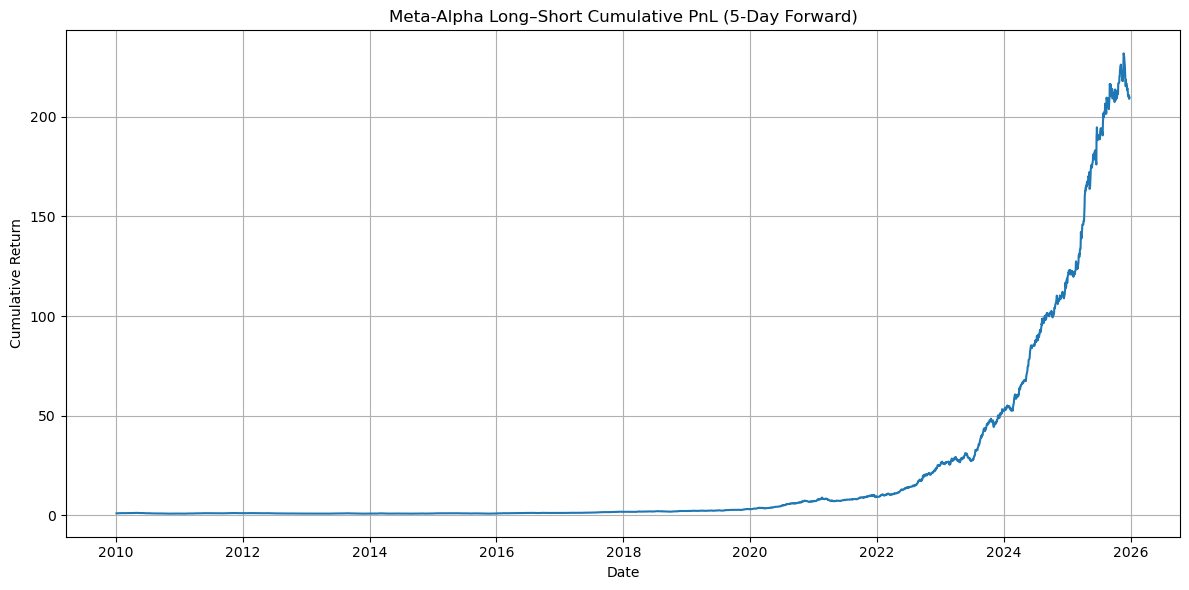


LONG–SHORT PERFORMANCE STATS
Mean daily LS return: 0.1397%
Daily volatility:     1.1293%
Annualized Sharpe:    1.96

✓ TEST COMPLETE!

Next steps:
  2. Adjust forward_days for different holding periods
  3. Use meta_alpha for portfolio construction
  4. Backtest the meta-alpha strategy


In [59]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

class MetaAlphaCreator:
    """
    Creates a meta-alpha by combining multiple Alpha101 factors using Lasso regression.
    Handles look-ahead bias, proper cross-validation, and normalization.
    """
    
    def __init__(self, alpha_list=None, lookback_days=252, forward_days=1):
        """
        Parameters:
        -----------
        alpha_list : list, optional
            List of alpha numbers to use (1-126). If None, uses all compatible alphas.
        lookback_days : int
            Training window size in days
        forward_days : int
            Forward return period (default: 1 day)
        """
        self.alpha_list = alpha_list or list(range(1, 127))
        self.lookback_days = lookback_days
        self.forward_days = forward_days
        self.coef_ = None
        self.selected_alphas_ = None
        
        # Alphas known to have issues
        self.incompatible_alphas = []
        #self.incompatible_alphas = [4, 13, 15, 16, 22, 23, 26, 33, 40, 44, 46, 
        #                             55, 60, 116, 124, 125, 126]
        
    def compute_alpha(self, alpha_calc, alpha_num):
        """
        Safely compute a single alpha factor.
        
        Parameters:
        -----------
        alpha_calc : Alpha101 instance
        alpha_num : int
            Alpha number (1-126)
            
        Returns:
        --------
        pd.Series or None if alpha fails
        """
        try:
            # Your Alpha101 uses alpha_001, alpha_002, etc. format
            method_name = f'alpha_{str(alpha_num).zfill(3)}'
            alpha_func = getattr(alpha_calc, method_name, None)
            
            if alpha_func is None:
                print(f"  ✗ Alpha {alpha_num}: method not found")
                return None
            
            result = alpha_func()
            
            if result is None or len(result) == 0:
                print(f"  ✗ Alpha {alpha_num}: returned None/empty")
                return None
            
            # Convert to Series if DataFrame
            if isinstance(result, pd.DataFrame):
                if result.shape[1] == 1:
                    result = result.iloc[:, 0]
                else:
                    print(f"  ✗ Alpha {alpha_num}: returned multi-column DataFrame")
                    return None
            
            # Ensure it's a Series
            if not isinstance(result, pd.Series):
                result = pd.Series(result)
            
            print(f"  ✓ Alpha {alpha_num}: computed successfully")
            return result
            
        except Exception as e:
            print(f"  ✗ Alpha {alpha_num}: {str(e)[:80]}")
            return None
    
    def build_alpha_matrix(self, df, alpha_calc):
        """
        Build matrix of alpha factors.
        
        Parameters:
        -----------
        df : pd.DataFrame
            Stock data with columns: date, symbol, open, high, low, close, volume
        alpha_calc : Alpha101 instance
            
        Returns:
        --------
        pd.DataFrame with alpha values
        """
        print("\n" + "="*60)
        print("Building Alpha Matrix")
        print("="*60)
        
        alpha_matrix = pd.DataFrame(index=df.index)
        successful_alphas = []
        
        for alpha_num in self.alpha_list:
            if alpha_num in self.incompatible_alphas:
                print(f"  ⊗ Alpha {alpha_num}: skipped (known incompatible)")
                continue
            
            alpha_series = self.compute_alpha(alpha_calc, alpha_num)
            
            if alpha_series is None:
                continue
            
            alpha_series_aligned = pd.Series(alpha_series.values, index=alpha_matrix.index)
    
            # Replace inf → NaN
            alpha_series_aligned.replace([np.inf, -np.inf], np.nan, inplace=True)
            
            # Skip alpha if too sparse
            nan_ratio = alpha_series_aligned.isna().mean()
            if nan_ratio > 0.3:
                print(f"  ✗ Alpha {alpha_num}: dropped (NaN ratio {nan_ratio:.2f})")
                continue
            
            # Winsorize safely
            std = alpha_series_aligned.std(skipna=True)
            mean = alpha_series_aligned.mean(skipna=True)
            
            if std > 0:
                alpha_series_aligned = alpha_series_aligned.clip(
                    mean - 10 * std,
                    mean + 10 * std
                )
            
            alpha_matrix[f'alpha{alpha_num}'] = alpha_series_aligned
            successful_alphas.append(alpha_num)
        
        # Drop columns that are entirely NaN
        alpha_matrix = alpha_matrix.dropna(axis=1, how='all')
        
        print(f"\n✓ Successfully computed {len(successful_alphas)} alphas")
        print(f"  Alphas: {successful_alphas}")
        print(f"  Matrix shape: {alpha_matrix.shape}")
        
        return alpha_matrix, successful_alphas
    
    def prepare_data(self, df, alpha_matrix):
        """
        Prepare X (features) and y (target) with proper alignment.
        CRITICAL: Prevents look-ahead bias.
        
        Parameters:
        -----------
        df : pd.DataFrame
            Original stock data
        alpha_matrix : pd.DataFrame
            Computed alpha values
            
        Returns:
        --------
        X, y, dates, symbols aligned properly
        """
        print("\n" + "="*60)
        print("Preparing Training Data")
        print("="*60)
        
        # Compute FUTURE return (target)
        # CRITICAL: Use forward_days periods ahead
        df_copy = df.copy()
        df_copy['future_ret'] = df_copy.groupby('symbol')['close'].shift(-self.forward_days) / df_copy['close'] - 1
        
        # Extract target
        y = df_copy['future_ret']
        
        # Extract dates and symbols for later analysis
        dates = df_copy['date'] if 'date' in df_copy.columns else df_copy.index
        symbols = df_copy['symbol'] if 'symbol' in df_copy.columns else None
        
        # Build X from alpha_matrix
        X = alpha_matrix.copy()
        
        # Step 1: Drop rows where ALL alphas are NaN
        mask_X = ~X.isna().all(axis=1)
        X = X[mask_X]
        y = y[mask_X]
        dates = dates[mask_X]
        if symbols is not None:
            symbols = symbols[mask_X]
        
        # Step 2: Drop rows where target y is NaN (last forward_days periods per stock)
        mask_y = ~y.isna()
        X = X[mask_y]
        y = y[mask_y]
        dates = dates[mask_y]
        if symbols is not None:
            symbols = symbols[mask_y]
        
        print(f"  Original data points: {len(df)}")
        print(f"  After removing NaN alphas: {mask_X.sum()}")
        print(f"  After removing NaN targets: {mask_y.sum()}")
        print(f"  Final training samples: {len(X)}")
        
        return X, y, dates, symbols
    
    def fit(self, df, alpha_calc, cv_folds=5):
        """
        Fit Lasso model to select best alphas.
        Uses TimeSeriesSplit for proper cross-validation.
        
        Parameters:
        -----------
        df : pd.DataFrame
            Stock data
        alpha_calc : Alpha101 instance
        cv_folds : int
            Number of time-series CV folds
        """
        print("\n" + "="*60)
        print("FITTING META-ALPHA MODEL")
        print("="*60)
        
        # Build alpha matrix
        alpha_matrix, successful_alphas = self.build_alpha_matrix(df, alpha_calc)
        
        # Prepare data
        X, y, dates, symbols = self.prepare_data(df, alpha_matrix)
        
        # Normalize features (critical for Lasso)
        print("\n" + "="*60)
        print("Normalizing Features")
        print("="*60)

                # ================= INF CHECK =================
        inf_count = np.isinf(X.values).sum()
        print(f"  Infinite values in X: {inf_count}")
        
        if inf_count > 0:
            bad_cols = X.columns[np.isinf(X).any()]
            print("  Columns with inf:", bad_cols.tolist())
        
        # Replace infinities safely
        X = X.replace([np.inf, -np.inf], np.nan)
        
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(
            scaler.fit_transform(X.fillna(X.mean())),
            columns=X.columns,
            index=X.index
        )
        
        print("  ✓ Features normalized (mean=0, std=1)")
        
        # Time-series cross-validation
        print("\n" + "="*60)
        print("Training with Time-Series Cross-Validation")
        print("="*60)
        
        tscv = TimeSeriesSplit(n_splits=cv_folds)
        
        # Fit LassoCV with time-series splits
        lasso = LassoCV(
            cv=tscv,
            random_state=42,
            max_iter=10000,
            n_jobs=-1
        )
        
        lasso.fit(X_scaled, y)
        
        print(f"  ✓ Optimal alpha (regularization): {lasso.alpha_:.6f}")
        print(f"  ✓ Cross-validated R²: {lasso.score(X_scaled, y):.4f}")
        
        # Extract coefficients
        self.coef_ = pd.Series(lasso.coef_, index=X_scaled.columns)
        self.selected_alphas_ = self.coef_[self.coef_ != 0]
        
        print("\n" + "="*60)
        print("SELECTED ALPHAS (Non-Zero Coefficients)")
        print("="*60)
        print(self.selected_alphas_.sort_values(ascending=False))
        print(f"\nTotal selected: {len(self.selected_alphas_)} / {len(self.coef_)}")
        
        # Store scaler and filled X for prediction
        self.scaler_ = scaler
        self.X_filled_ = X.fillna(X.mean())
        
        return self
    
    def predict(self, X_new):
        """
        Predict using fitted meta-alpha.
        
        Parameters:
        -----------
        X_new : pd.DataFrame
            New alpha values
            
        Returns:
        --------
        pd.Series of predicted returns
        """
        if self.coef_ is None:
            raise ValueError("Model not fitted. Call fit() first.")
        
        # Fill NaN and scale
        X_filled = X_new.fillna(X_new.mean())
        X_scaled = pd.DataFrame(
            self.scaler_.transform(X_filled),
            columns=X_filled.columns,
            index=X_filled.index
        )
        
        # Predict
        meta_alpha = X_scaled.dot(self.coef_)
        
        return meta_alpha
    
    def get_meta_alpha(self):
        """
        Get the meta-alpha values for the training data.
        
        Returns:
        --------
        pd.Series of meta-alpha values
        """
        if self.coef_ is None:
            raise ValueError("Model not fitted. Call fit() first.")
        
        X_scaled = pd.DataFrame(
            self.scaler_.transform(self.X_filled_),
            columns=self.X_filled_.columns,
            index=self.X_filled_.index
        )
        
        meta_alpha = X_scaled.dot(self.coef_)
        
        return meta_alpha
    
    def analyze_performance(self, meta_alpha, y):
        """
        Analyze the meta-alpha performance.
        
        Parameters:
        -----------
        meta_alpha : pd.Series
            Meta-alpha values
        y : pd.Series
            Actual returns
        """
        print("\n" + "="*60)
        print("META-ALPHA PERFORMANCE ANALYSIS")
        print("="*60)
        
        # Align series
        aligned = pd.DataFrame({'meta_alpha': meta_alpha, 'return': y}).dropna()
        
        # Correlation
        corr = aligned['meta_alpha'].corr(aligned['return'])
        print(f"Correlation with returns: {corr:.4f}")
        
        # Rank correlation (more robust)
        rank_corr = aligned['meta_alpha'].corr(aligned['return'], method='spearman')
        print(f"Rank correlation (Spearman): {rank_corr:.4f}")
        
        # Quintile analysis
        aligned['quintile'] = pd.qcut(aligned['meta_alpha'], 5, labels=[1,2,3,4,5], duplicates='drop')
        quintile_returns = aligned.groupby('quintile')['return'].mean()
        
        print(f"\nQuintile Returns (1=lowest, 5=highest meta-alpha):")
        for q, ret in quintile_returns.items():
            print(f"  Q{q}: {ret*100:.3f}%")
        
        spread = quintile_returns.iloc[-1] - quintile_returns.iloc[0]
        print(f"\nLong-Short Spread (Q5-Q1): {spread*100:.3f}%")


# ============================================================
# USAGE EXAMPLE WITH BIST100 DATA
# ============================================================

if __name__ == "__main__":
    """
    Test with BIST100 data - first 10 alphas
    """
    
    print("="*60)
    print("TESTING META-ALPHA WITH BIST100 DATA")
    print("="*60)
    
    # Step 1: Load structured BIST100 data
    print("\n[1/5] Loading BIST100 data...")
    from pathlib import Path
    
    # Try to load from pickle first (fast)
    pickle_path = 'bist100_data.pkl'
    if Path(pickle_path).exists():
        print(f"  Loading from pickle: {pickle_path}")
        loader = StockDataLoader('dummy')
        loader.load_structured_data(pickle_path)
    else:
        print(f"  Pickle not found, loading from CSVs...")
        folder_path = r'C:\Users\TESLA\Desktop\datasets\bist_100_2010-2025_daily'
        loader = StockDataLoader(folder_path)
        loader.load_all_files()
        loader.structure_data()
        loader.save_structured_data(pickle_path)
    
    # Step 2: Convert to long format for Alpha101
    print("\n[2/5] Converting to long format...")
    
    # Your Alpha101 expects long format with columns: symbol, date, open, high, low, close, volume
    # Stack to long format
    close_df = loader.data['close']
    open_df = loader.data['open']
    high_df = loader.data['high']
    low_df = loader.data['low']
    volume_df = loader.data['volume']
    
    data_list = []
    for stock in loader.stocks:
        stock_data = pd.DataFrame({
            'symbol': stock,
            'date': close_df.index,
            'open': open_df[stock],
            'high': high_df[stock],
            'low': low_df[stock],
            'close': close_df[stock],
            'volume': volume_df[stock],
            'returns': close_df[stock].pct_change()  # Add returns column that Alpha101 needs
        })
        data_list.append(stock_data)
    
    df = pd.concat(data_list, ignore_index=True)
    df = df.dropna(subset=['close'])  # Remove rows with no price data
    df = df.sort_values(['symbol', 'date']).reset_index(drop=True)

    # Typical price
    tp = (df['high'] + df['low'] + df['close']) / 3
    
    df['vwap'] = (
        (tp * df['volume'])
        .groupby(df['symbol'])
        .cumsum()
        / df['volume'].groupby(df['symbol']).cumsum()
    )

    for w in [10, 15, 20, 30, 40, 60, 120, 180]:
        df[f'adv{w}'] = (
            df.groupby('symbol')['volume']
              .transform(lambda x: x.rolling(w, min_periods=w).mean())
        )


    print(f"  Long format shape: {df.shape}")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"  Unique stocks: {df['symbol'].nunique()}")
    print(f"  Columns: {df.columns.tolist()}")
    print(f"\n  Sample data:")
    print(df.head(10))
    
    # Step 3: Initialize Alpha101
    print("\n[3/5] Initializing Alpha101 calculator...")
    
    # Your Alpha101 takes the dataframe directly
    try:
        # Assuming your Alpha101 class is in a file called alpha101.py
        # If it's in a different file, adjust the import
        import sys
        sys.path.append('.')  # Add current directory to path
        
        # Try to import
        try:
            from alpha101 import Alpha101
        except ImportError:
            # If that fails, try to define it inline (you can paste your Alpha101 class here)
            print("  ⚠ Could not import Alpha101 from alpha101.py")
            print("  Please ensure your Alpha101 class is available")
            print("\n  Expected Alpha101 signature:")
            print("    class Alpha101:")
            print("        def __init__(self, data):")
            print("            self.data = data  # DataFrame with symbol, date, OHLCV, returns")
            print("        def alpha_001(self): ...")
            print("        def alpha_002(self): ...")
            raise
        
        # Initialize with your data
        alpha_calc = Alpha101(df)
        print("  ✓ Alpha101 initialized")
        print(f"  Data shape: {alpha_calc.data.shape}")
        print(f"  Columns available: {alpha_calc.data.columns.tolist()}")

        df['target'] = (
            df.groupby('symbol')['returns']
              .shift(-1)
        )
        
        TCOST = 0.0005  # 5 bps transaction cost
        df['target_net'] = df['target'] - TCOST
        

        test_alphas = list(range(1, 51))  
        
        meta = MetaAlphaCreator(alpha_list=test_alphas, forward_days=5) #was 1
        meta.fit(df, alpha_calc, cv_folds=3)
        
        # Step 5: Analyze results
        print("\n[5/5] Analyzing meta-alpha performance...")
        meta_alpha = meta.get_meta_alpha()
        
        # Get corresponding returns
        y = df['target_net']
        y = y.loc[meta_alpha.index]

        
        meta.analyze_performance(meta_alpha, y)


        pnl_df = df.loc[meta_alpha.index, ['date', 'symbol', 'target_net']].copy()
        pnl_df['meta_alpha'] = meta_alpha.values
        
        assert pnl_df[['meta_alpha', 'target_net']].notna().all().all()

        def compute_long_short_returns(df, q=0.2):
            daily_ls = []
        
            for date, g in df.groupby('date'):
                g = g.dropna(subset=['meta_alpha', 'target_net'])
                if len(g) < 20:
                    continue
        
                g = g.sort_values('meta_alpha')
                n = int(len(g) * q)
                if n == 0:
                    continue
        
                short_ret = g.iloc[:n]['target_net'].mean()
                long_ret  = g.iloc[-n:]['target_net'].mean()
        
                daily_ls.append({
                    'date': date,
                    'long_short_ret': long_ret - short_ret
                })

            return pd.DataFrame(daily_ls).set_index('date')
            
        ls_returns = compute_long_short_returns(pnl_df, q=0.2)
        
        ls_returns['cum_pnl'] = (1 + ls_returns['long_short_ret']).cumprod()
            
        plt.figure(figsize=(12, 6))
        plt.plot(ls_returns.index, ls_returns['cum_pnl'])
        plt.title('Meta-Alpha Long–Short Cumulative PnL (5-Day Forward)')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        mean_daily = ls_returns['long_short_ret'].mean()
        std_daily  = ls_returns['long_short_ret'].std()
        sharpe = mean_daily / std_daily * np.sqrt(252)
        
        print("\nLONG–SHORT PERFORMANCE STATS")
        print(f"Mean daily LS return: {mean_daily:.4%}")
        print(f"Daily volatility:     {std_daily:.4%}")
        print(f"Annualized Sharpe:    {sharpe:.2f}")
                    
        print("\n" + "="*60)
        print("✓ TEST COMPLETE!")
        print("="*60)
        print("\nNext steps:")
        print("  2. Adjust forward_days for different holding periods")
        print("  3. Use meta_alpha for portfolio construction")
        print("  4. Backtest the meta-alpha strategy")
        
    except ImportError:
        print("\n⚠ Alpha101 class not found!")
        print("\nTo use this, you need:")
        print("  1. Your Alpha101 class implementation")
        print("  2. Import it: from alpha101 import Alpha101")
        print("\nData is ready in 'df' variable:")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {df.columns.tolist()}")
        print("\nYou can now manually test:")
        print("  alpha_calc = Alpha101(open=open_df, high=high_df, low=low_df, close=close_df, volume=volume_df)")
        print("  meta = MetaAlphaCreator(alpha_list=[1,2,3,4,5])")
        print("  meta.fit(df, alpha_calc)")
    
    except Exception as e:
        print(f"\n✗ Error during testing: {str(e)}")
        print("\nDebug info:")
        print(f"  df shape: {df.shape}")
        print(f"  df columns: {df.columns.tolist()}")
        import traceback
        traceback.print_exc()

In [ ]:
df = df.drop(columns=['return'], errors='ignore')

In [23]:
alpha_calc.alpha_002()

NameError: name 'alpha_calc' is not defined